### Setup

In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10) # set default size of plots
plt.rcParams['agg.path.chunksize'] = 10000
%config InlineBackend.figure_format = 'retina'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set_style("whitegrid")
sns.set_palette("bright")

### Helper Functions

In [2]:
def model(x, reuse=False):
    """
    2 Hidden Layer (5 x 5) neural network with RELU activation.
    """
    fc1 = layers.fully_connected(x, 50, activation_fn=tf.nn.relu, reuse=reuse)
    fc2 = layers.fully_connected(fc1, 50, activation_fn=tf.nn.relu, reuse=reuse)
    fc2 = layers.fully_connected(fc2, 50, activation_fn=tf.nn.relu, reuse=reuse)
    y = layers.fully_connected(fc2, 1, activation_fn=None, reuse=reuse)
    return y

def preprocess(X):
    """
    Scales and shifts X to have 0 mean and unit variance.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, scaler

def get_data(df, X_vars, y_vars, train_test_split=1.0):
    """
    Gets normalized features and the response variable from the dataframe.
    
    Args:
      - df: Pandas dataframe containing the input data.
      - X_vars: List of column names for the input matrix.
      - y_var: Column name for the output matrix.
      - train_test_split: Percentage of data to go in train.
    
    Returns:
        - X: Normalized input matrix containing X_vars.
        - y: Array containing the response variable.
        - X_scaler: Module used to normalize X.
    """
    # Filter out rows where one of the input variables and/or response variable is NaN.
    df = df[X_vars + y_vars].dropna()
    df = df.reindex(np.random.permutation(df.index))
    df_train = df.iloc[:int(df.shape[0] * train_test_split)]
    df_test = df.iloc[int(df.shape[0] * train_test_split):]
    X_train, X_scaler = preprocess(df_train[X_vars])
    X_test = X_scaler.transform(df_test[X_vars])
    y_train = df_train[y_vars]
    y_test = df_test[y_vars]
    return X_train, y_train, X_test, y_test, X_scaler

def plot_uniform_line(ax, X_uniform_inverse, uniform_preds, x_idx, y_idx):
    z = zip(X_uniform_inverse[:, x_idx], uniform_preds[:, y_idx])
    means = {}
    percentile_25 = {}
    percentile_75 = {}
    d = defaultdict(list)
    for x, y in z:
        d[x].append(y)
    for k, v in d.items():
        arr = np.array(v)
        means[k] = np.mean(arr)
        percentile_25[k] = np.percentile(arr, 25)
        percentile_75[k] = np.percentile(arr, 75)
    x, y_means = zip(*sorted(means.items()))
    x, y_25 = zip(*sorted(percentile_25.items()))
    x, y_75 = zip(*sorted(percentile_75.items()))
    ax.plot(x, y_means, c='g', label='Average of Uniform Predictions')
    ax.plot(x, y_25, c='c', label='25th percentile of Uniform Predictions')
    ax.plot(x, y_75, c='m', label='75th percentile of Uniform Predictions')

### Read in Data

In [3]:
df = pd.read_csv("data/h.data.csv") # dhmos
X_vars, y_vars, train_test_split = ["PPFD","TA","TS","VPD","WTD","USTAR","LE","GPP"], ["FCH4"], 0.8
X_train, y_train, X_val, y_val, X_scaler = get_data(df, X_vars, y_vars, train_test_split)
print "X_train: ", X_train.shape
print "X_val: ", X_val.shape
print "y_train: ", y_train.shape
print "y_val: ", y_val.shape

X_train:  (38853, 8)
X_val:  (9714, 8)
y_train:  (38853, 1)
y_val:  (9714, 1)


### Generate uniformly and gaussian distributed points

In [4]:
# Create a uniformly distributed meshgrid.
X_uniform = np.mgrid[-3:3.01:0.7, -3:3.01:0.7, -3:3.01:0.7, -3:3.01:0.7, -3:3.01:0.7, -3:3.01:0.7, -3:3.01:0.7, -3:3.01:0.7].reshape(X_train.shape[1],-1).T
# Sample 500000 points from the meshgrid.
X_uniform = X_uniform[np.random.choice(X_uniform.shape[0], 500000, replace=False), :]
# Normally distributed data.
X_gaussian = np.random.multivariate_normal([0] * X_train.shape[1], np.diag([1] * X_train.shape[1]), 50000)

### Initialize Tensorflow Variables and Prepare the Data for Training

In [5]:
# Split the data into batches
batch_size = 256
num_batches = X_train.shape[0] / batch_size
X_batches = np.array_split(X_train, num_batches)
# y_batches = np.array_split(y_train.values.reshape(-1, 1), num_batches)
y_batches = np.array_split(y_train, num_batches)

# Placeholders for the 
X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]])
# y = tf.placeholder(tf.float32, shape=[None, 1])
y = tf.placeholder(tf.float32, shape=[None, 1])
y_pred = model(X, reuse=False)

### More Tensorflow Setup

In [6]:
# Minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(y_pred - y))
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)

with tf.name_scope("summaries"):
    tf.summary.scalar("l2_loss", loss)
    summary_op = tf.summary.merge_all()

# Compute partial derivative of predictions w.r.t. input.
partial_x = tf.gradients(y_pred, X)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.global_variables_initializer()

### Training and Inference

In [8]:
save_dir = "tf_models/h/"
saver = tf.train.Saver()

train_mode = False

with tf.Session() as sess:
    if train_mode:
        sess.run(init)
        writer = tf.summary.FileWriter(save_dir, sess.graph)
        for epoch in xrange(500):
            for i in xrange(num_batches):
                # Train on batch i.
                _, batch_loss = sess.run([train, loss], feed_dict={X: X_batches[i], y: y_batches[i]})
            training_loss, summary = sess.run([loss, summary_op], feed_dict={X: X_train, y: y_train})
            if epoch % 10 == 0:
                val_loss = sess.run(loss, feed_dict={X: X_val, y: y_val})
                print "Epoch: ", epoch, "Training Loss: ", training_loss, "Validation Loss: ", val_loss
                saver.save(sess, save_dir, global_step=epoch)
            writer.add_summary(summary, global_step=epoch)
    else:
        latest_checkpoint = tf.train.latest_checkpoint(os.path.dirname(save_dir))
        if latest_checkpoint:
            saver.restore(sess, latest_checkpoint)
            print("Loaded from checkpoint {0}".format(latest_checkpoint))
        else:
            sess.run(tf.global_variables_initializer()) # no checkpoint found
            

    # Compute test predictions and partial derivatives w.r.t. input.
    preds, partials = sess.run([y_pred, partial_x], feed_dict={X: X_val})
    # Compute test predictions and partial derivatives w.r.t. input.
    preds, partials = sess.run([y_pred, partial_x], feed_dict={X: X_val})
    uniform_preds, uniform_partials = sess.run([y_pred, partial_x], feed_dict={X: X_uniform})
    gauss_preds, gauss_partials = sess.run([y_pred, partial_x], feed_dict={X: X_gaussian})

INFO:tensorflow:Restoring parameters from tf_models/h/-250
Loaded from checkpoint tf_models/h/-250


### Plots of Validation Samples and Predictions on Validation Samples

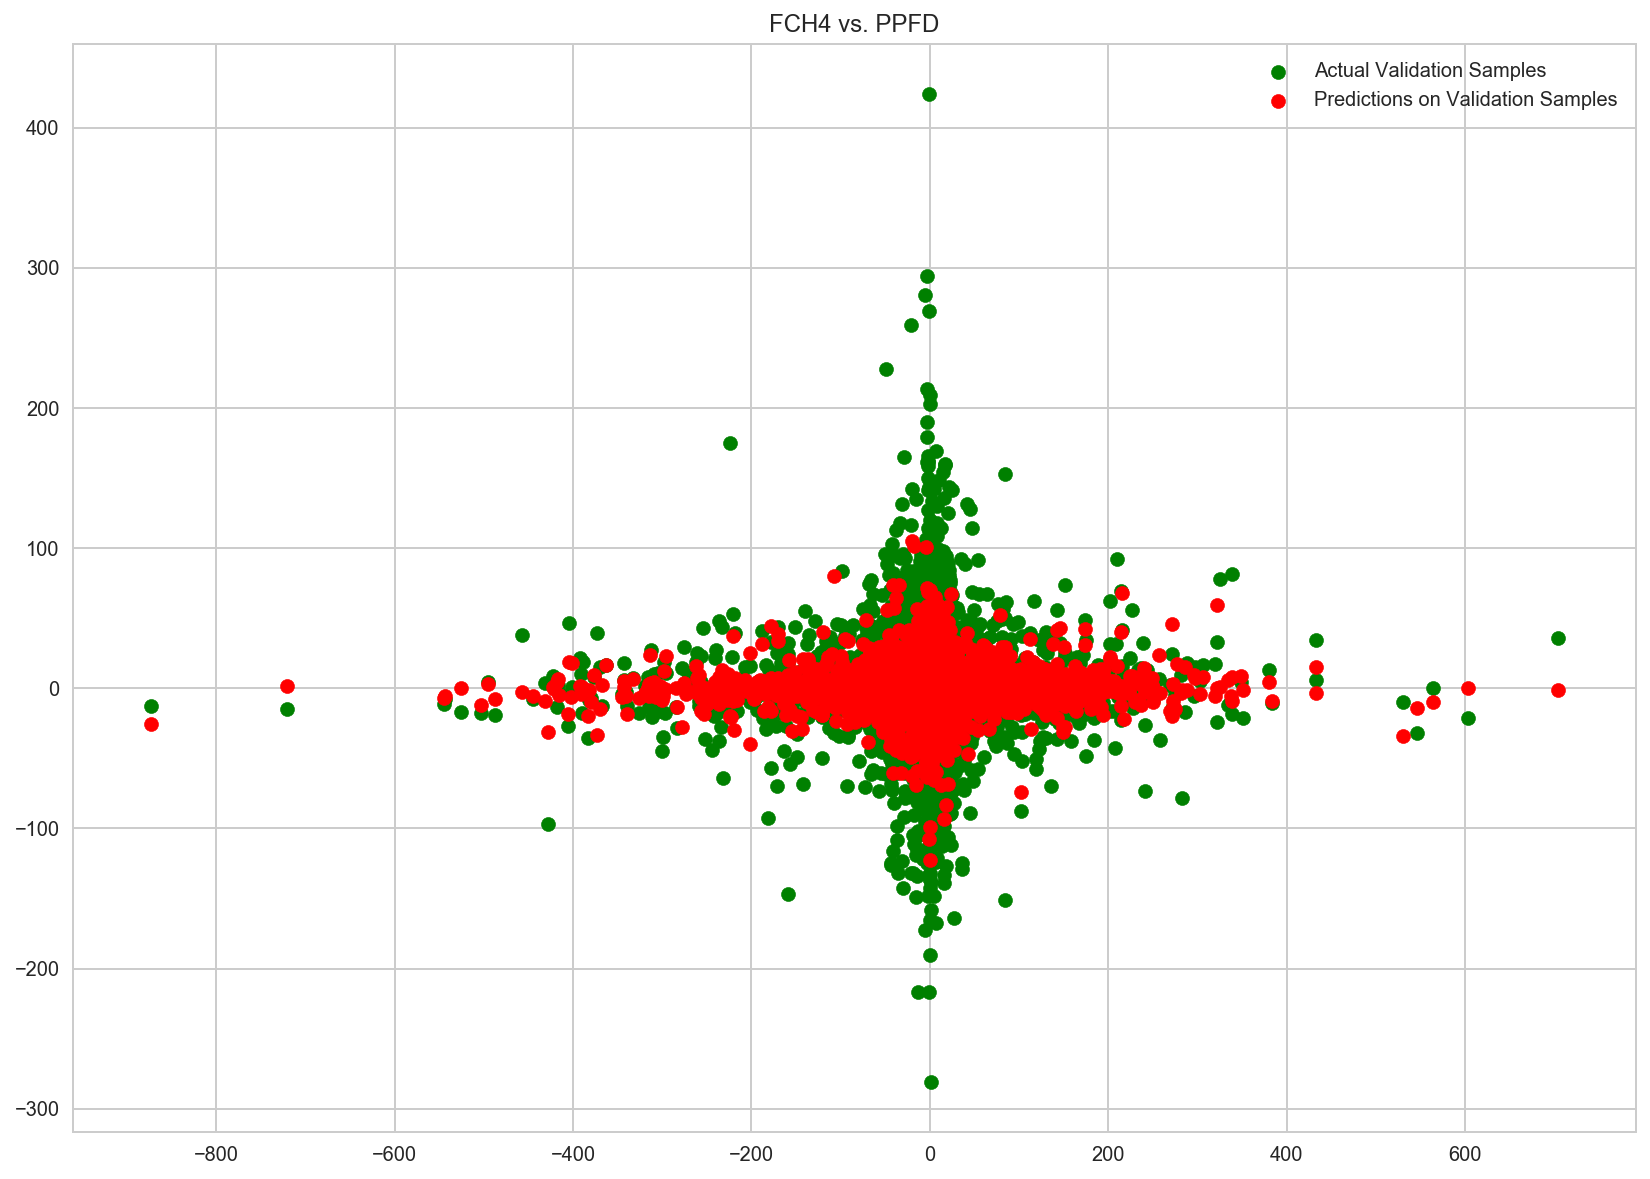

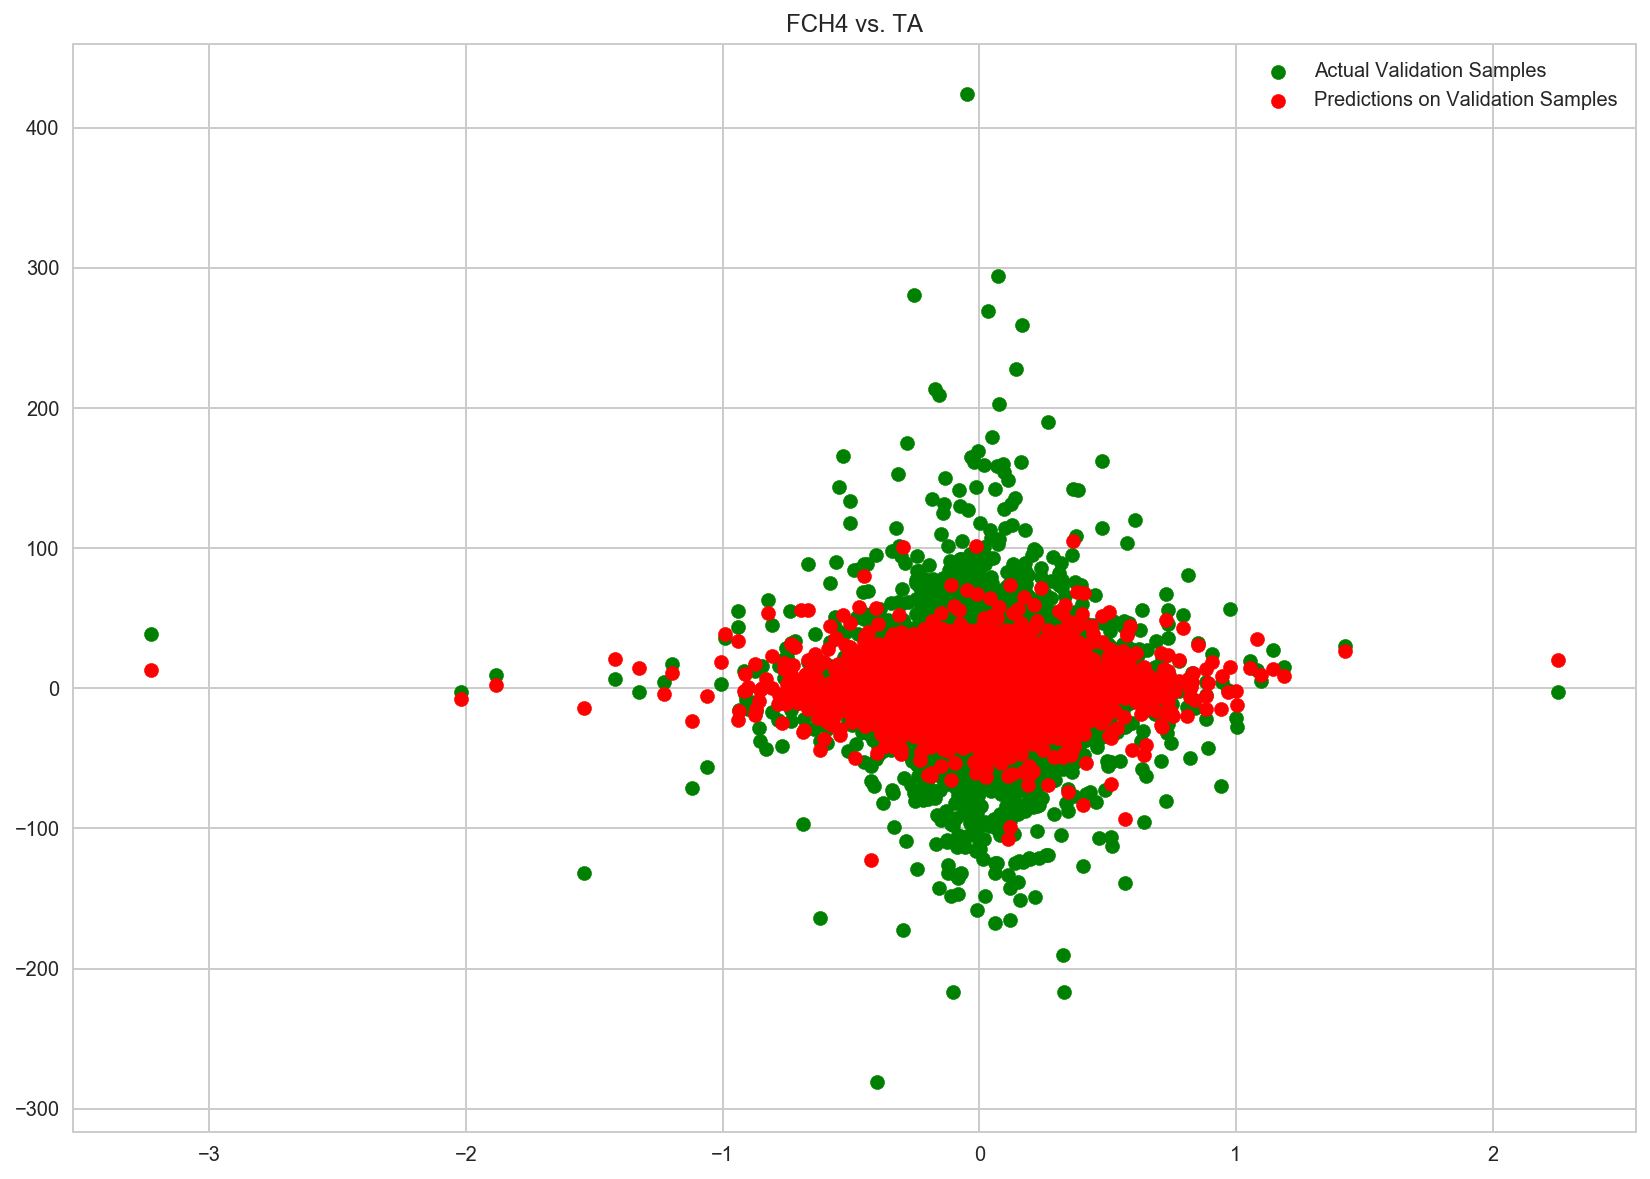

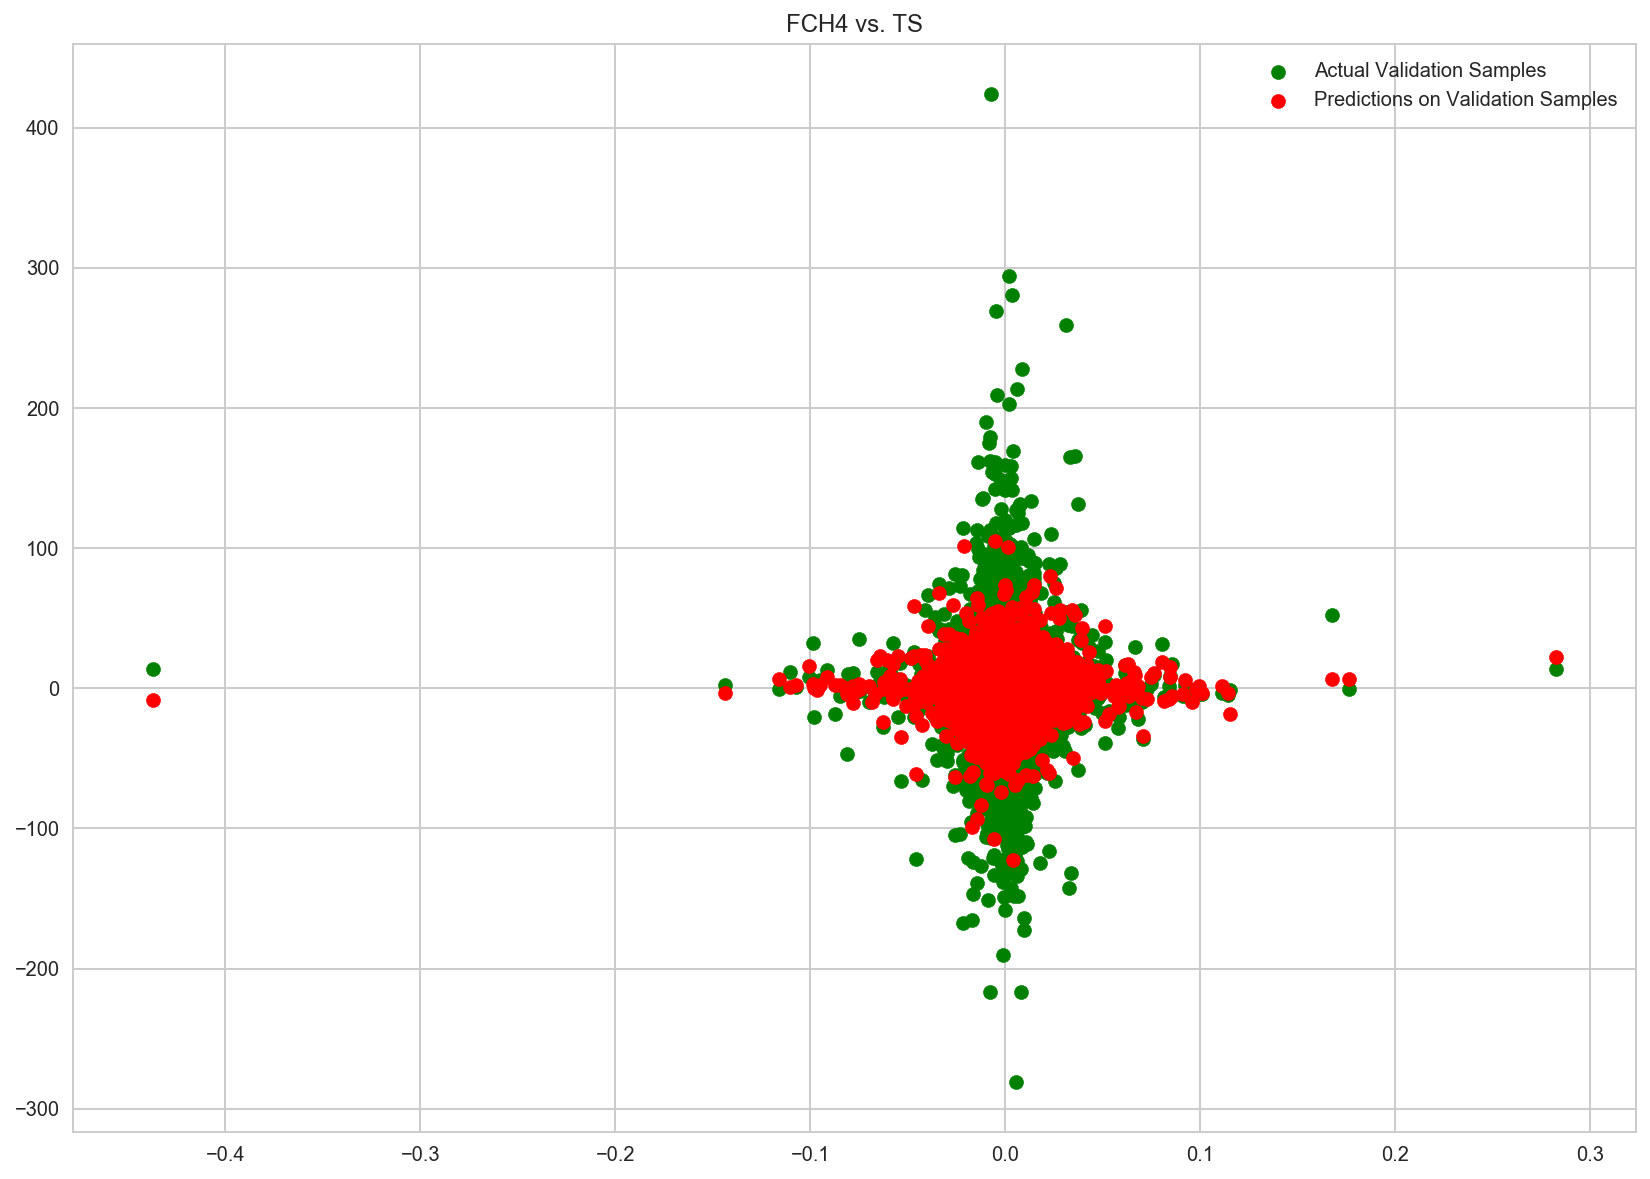

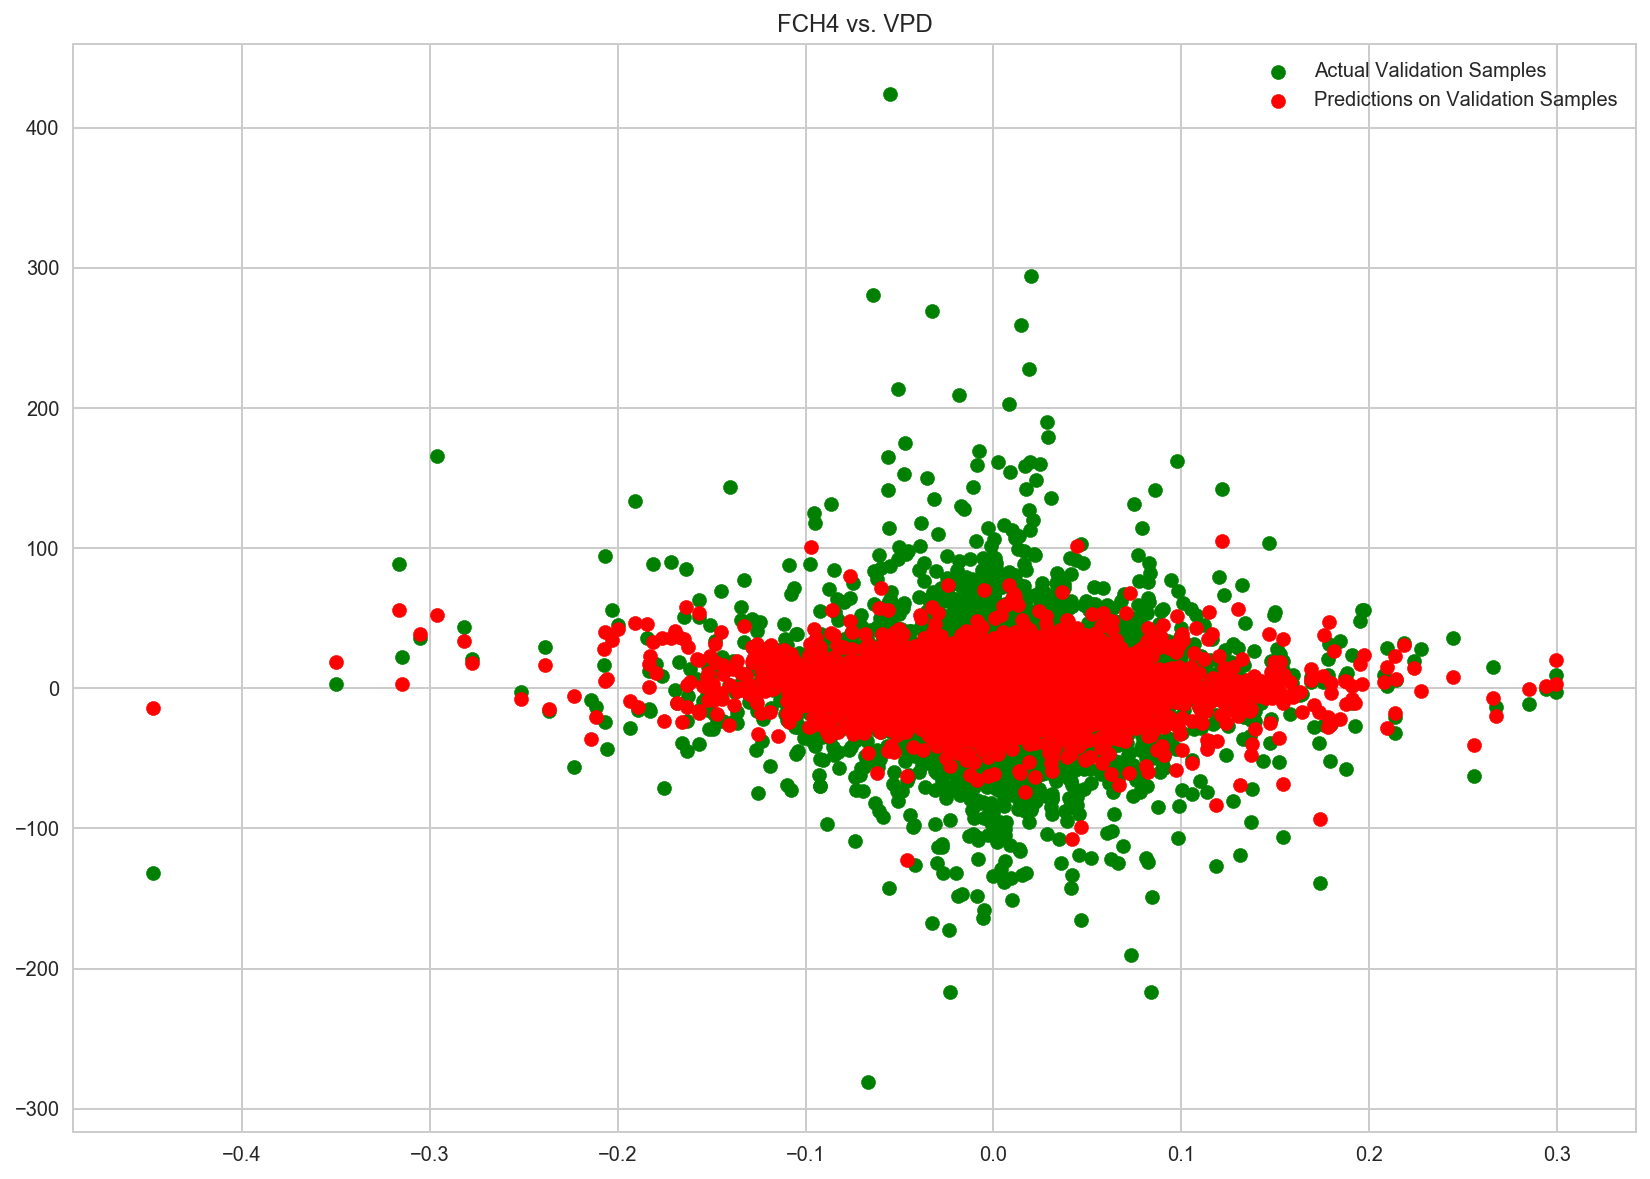

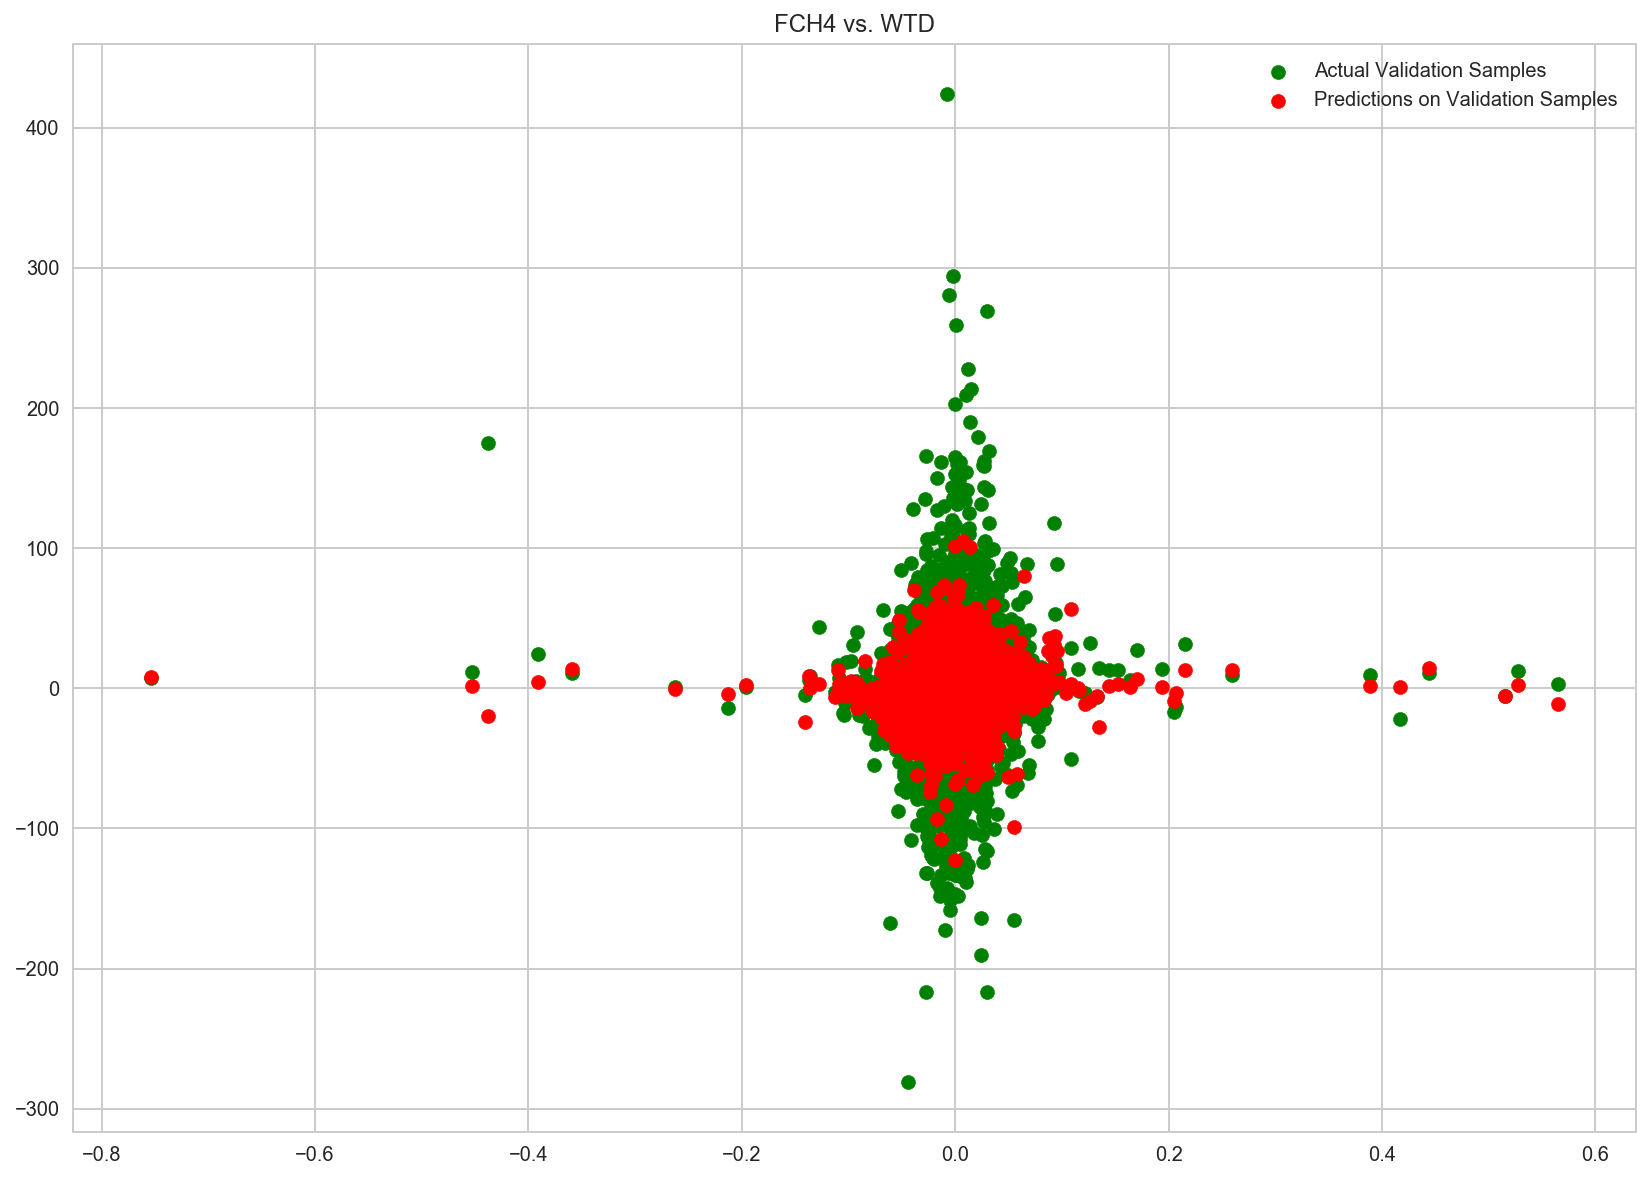

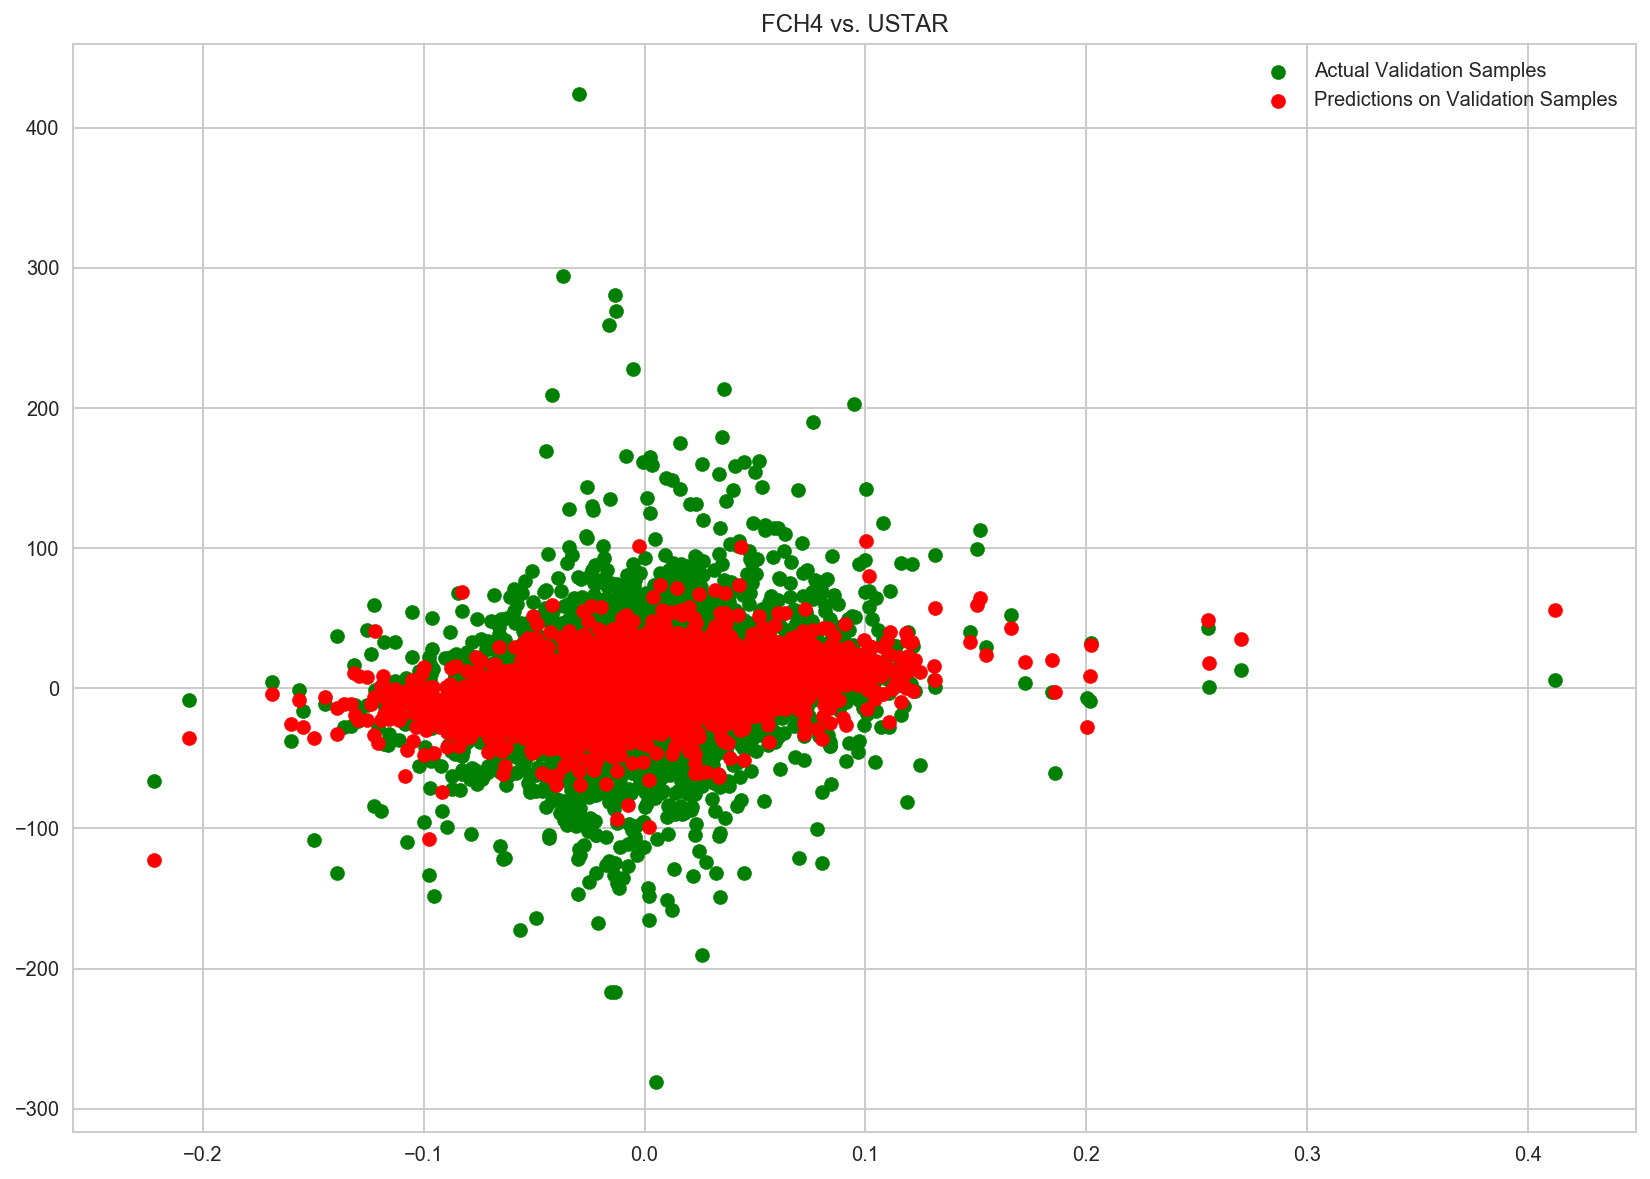

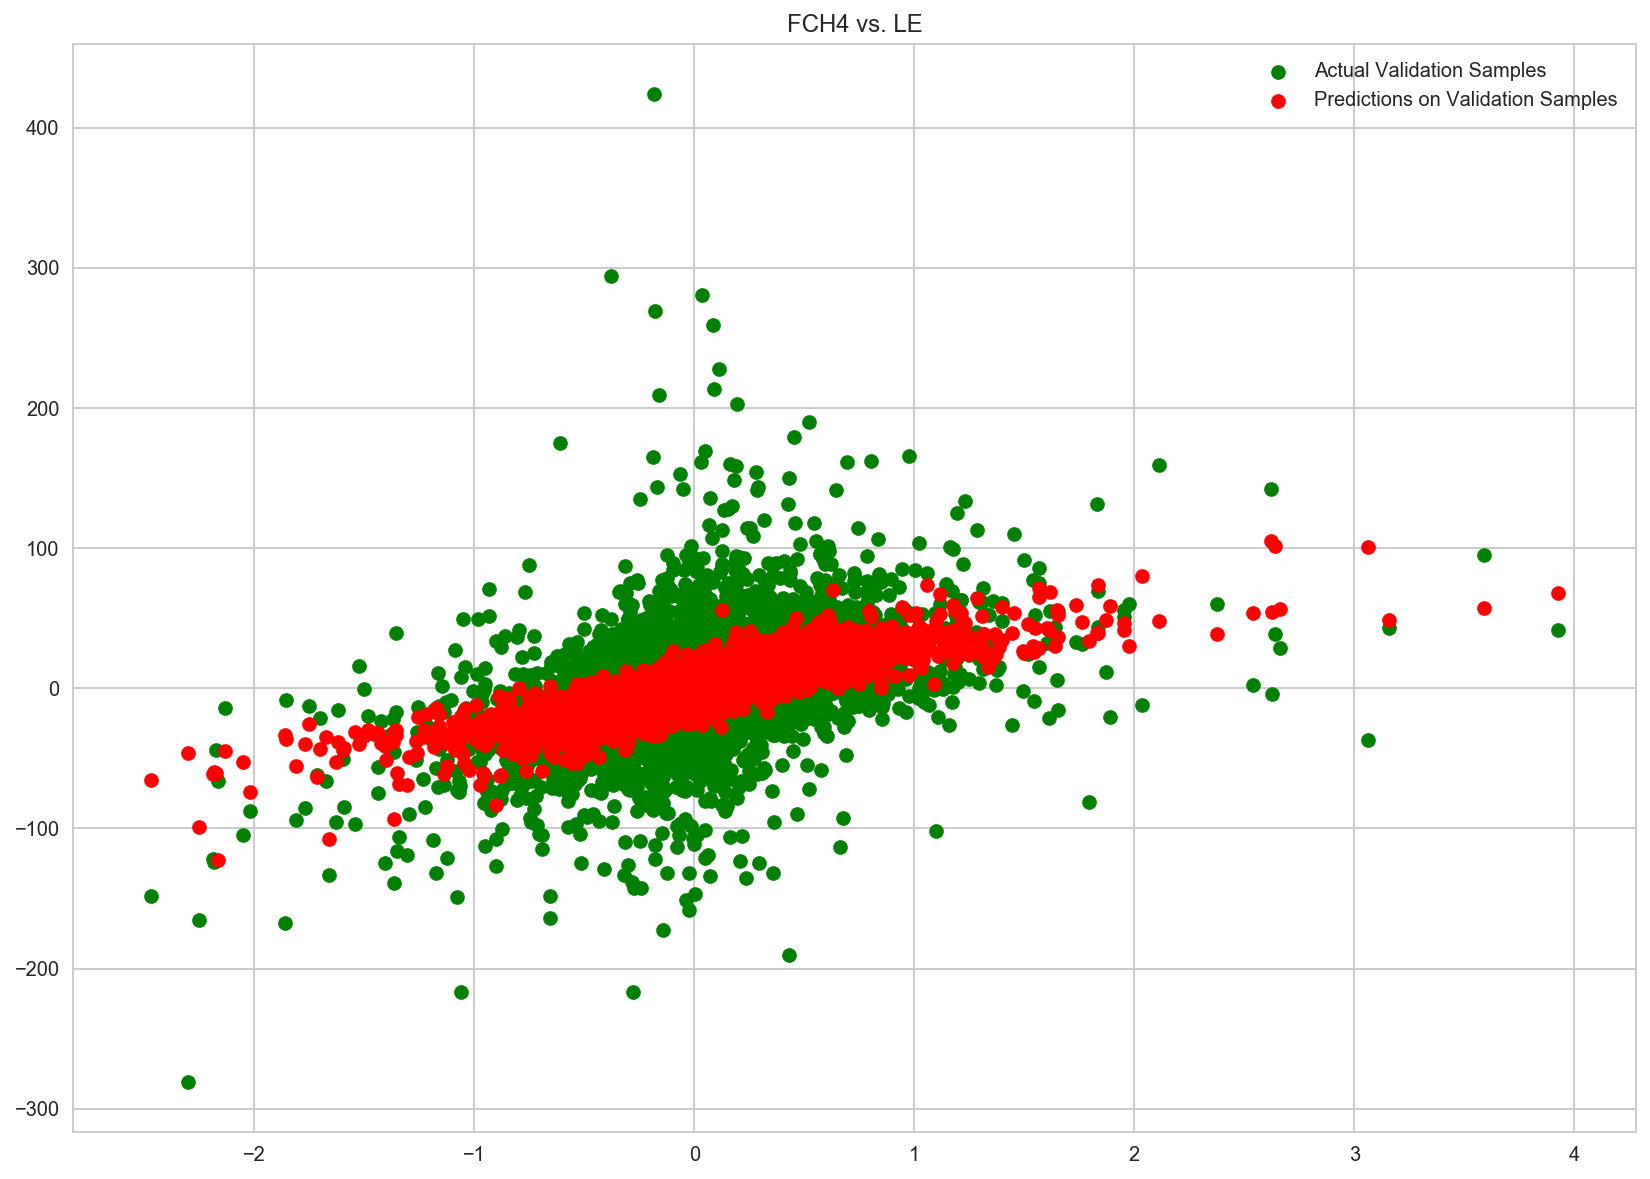

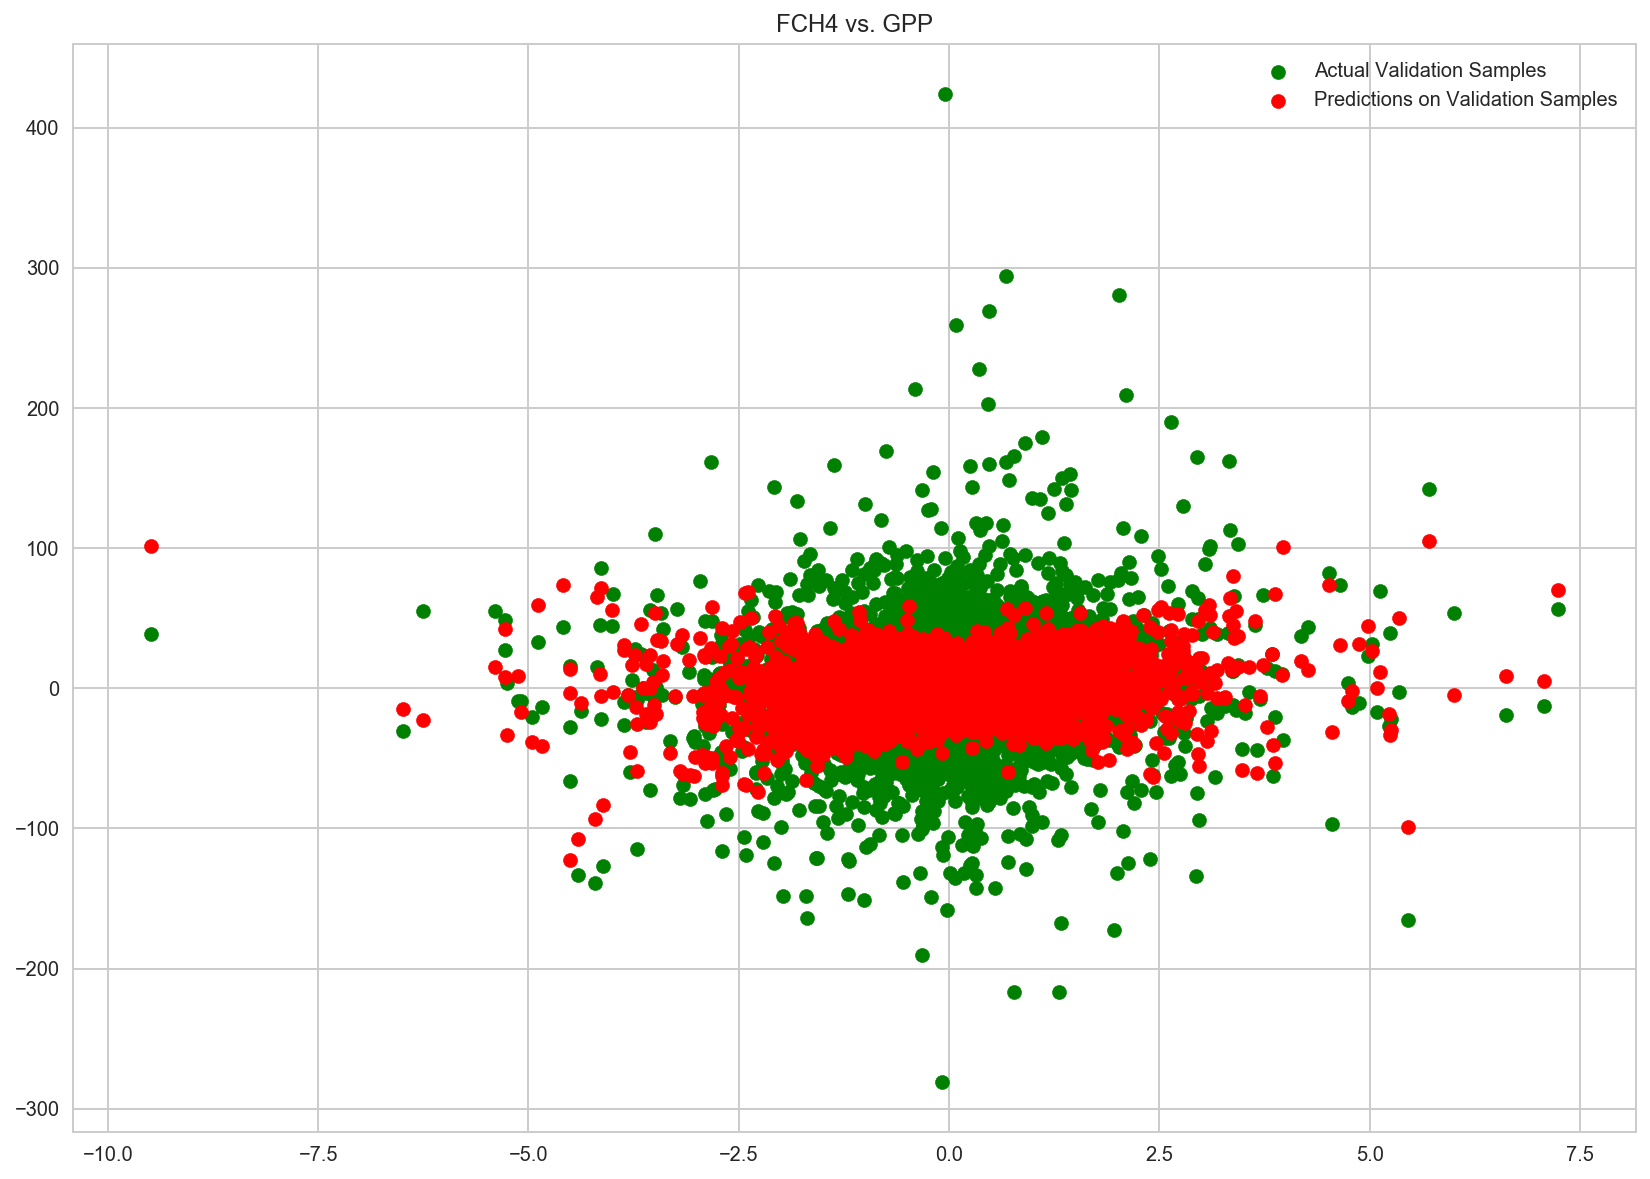

In [9]:
for i, x_var in enumerate(X_vars):
    for j, y_var in enumerate(y_vars):
        plt.title("{y_var} vs. {x_var}".format(y_var=y_var, x_var=x_var))
#         ax = sns.kdeplot(X_scaler.inverse_transform(X_val)[:, i], y_val[y_var], cmap="Blues", shade=True, shade_lowest=False)
#         sns.kdeplot(X_scaler.inverse_transform(X_val)[:, i], preds[:, j], cmap="Reds", shade=True, shade_lowest=False, ax=ax)
#         print preds[:, j].min(), preds[:, j].max()
#         ax.set_xlim((X_scaler.inverse_transform(X_val)[:, i].min(), X_scaler.inverse_transform(X_val)[:, i].max()))
#         ax.set_ylim((preds[:, j].min(), preds[:, j].max()))
        plt.scatter(X_scaler.inverse_transform(X_val)[:, i], y_val[y_var], c='g', label='Actual Validation Samples')
        plt.scatter(X_scaler.inverse_transform(X_val)[:, i], preds[:, j], c='r', label='Predictions on Validation Samples')
        plt.legend()
        plt.show()

### Setup for following cells

In [10]:
X_uniform_inverse = X_scaler.inverse_transform(X_uniform)
X_val_inverse = X_scaler.inverse_transform(X_val)

### Important plots

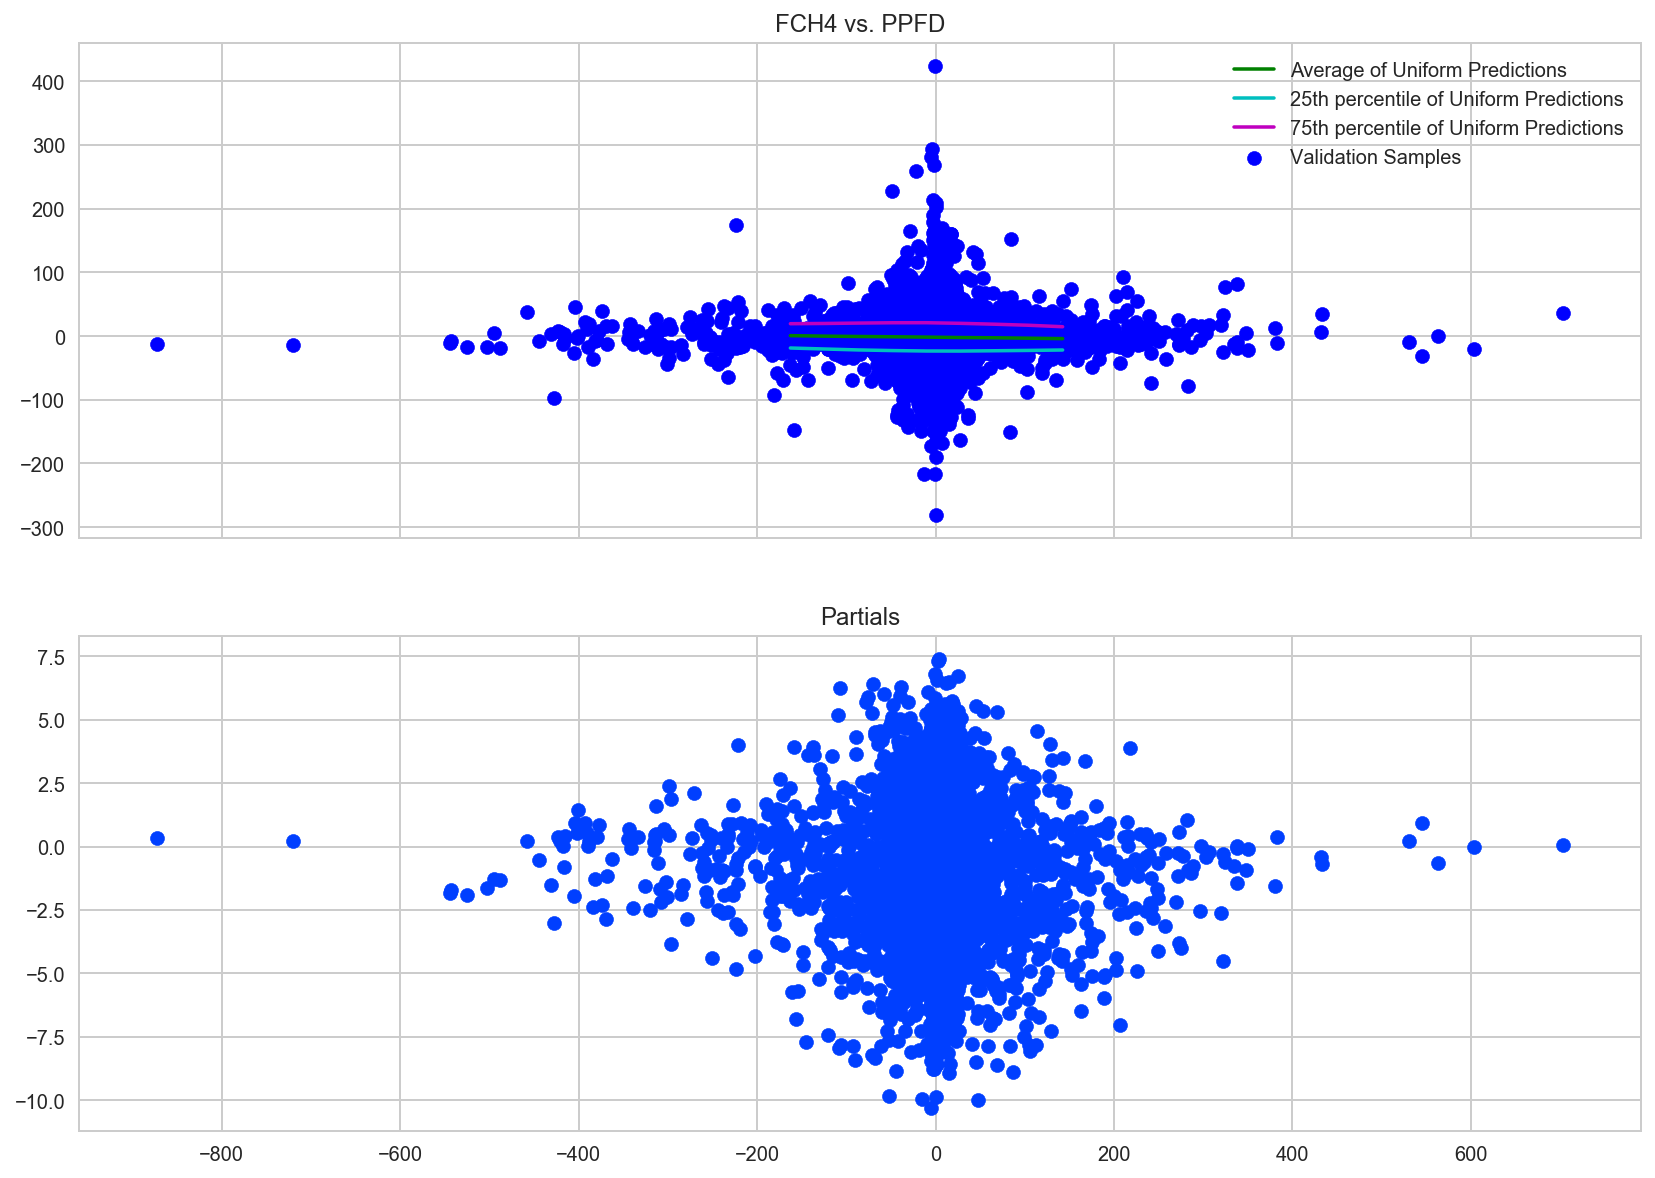

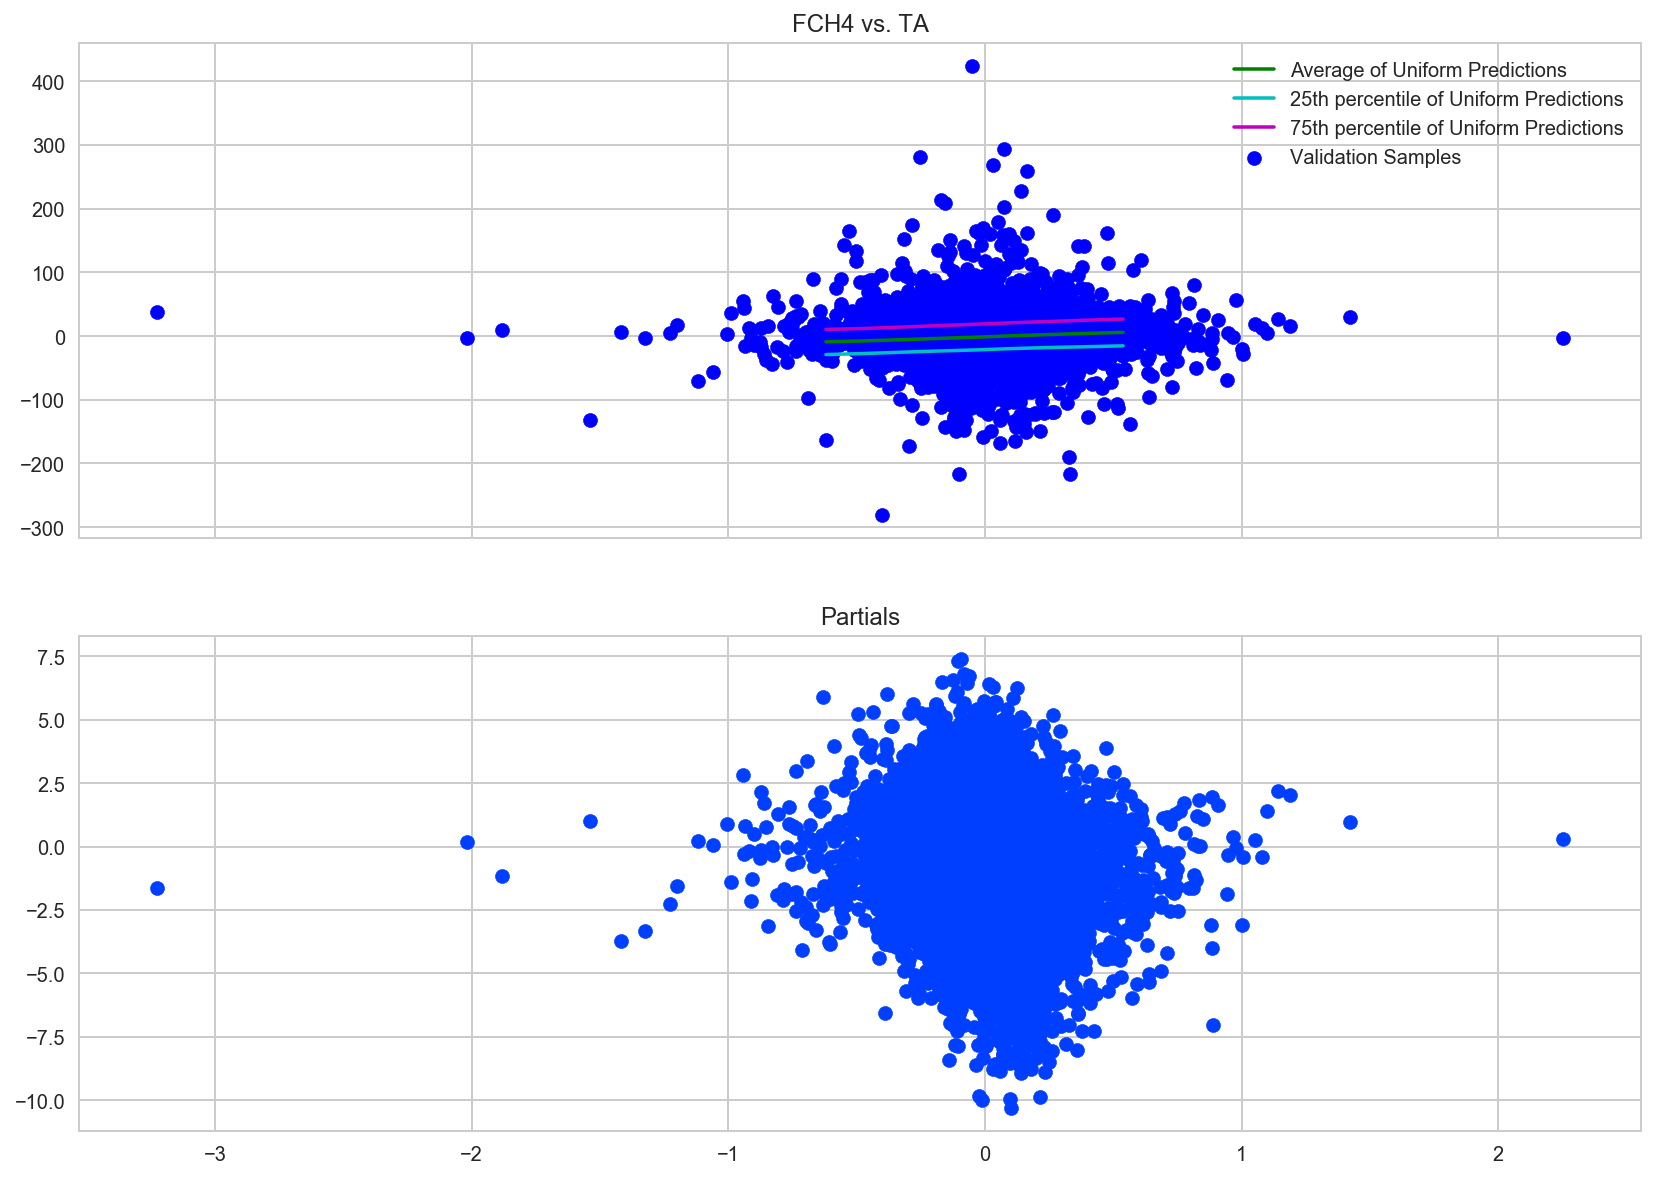

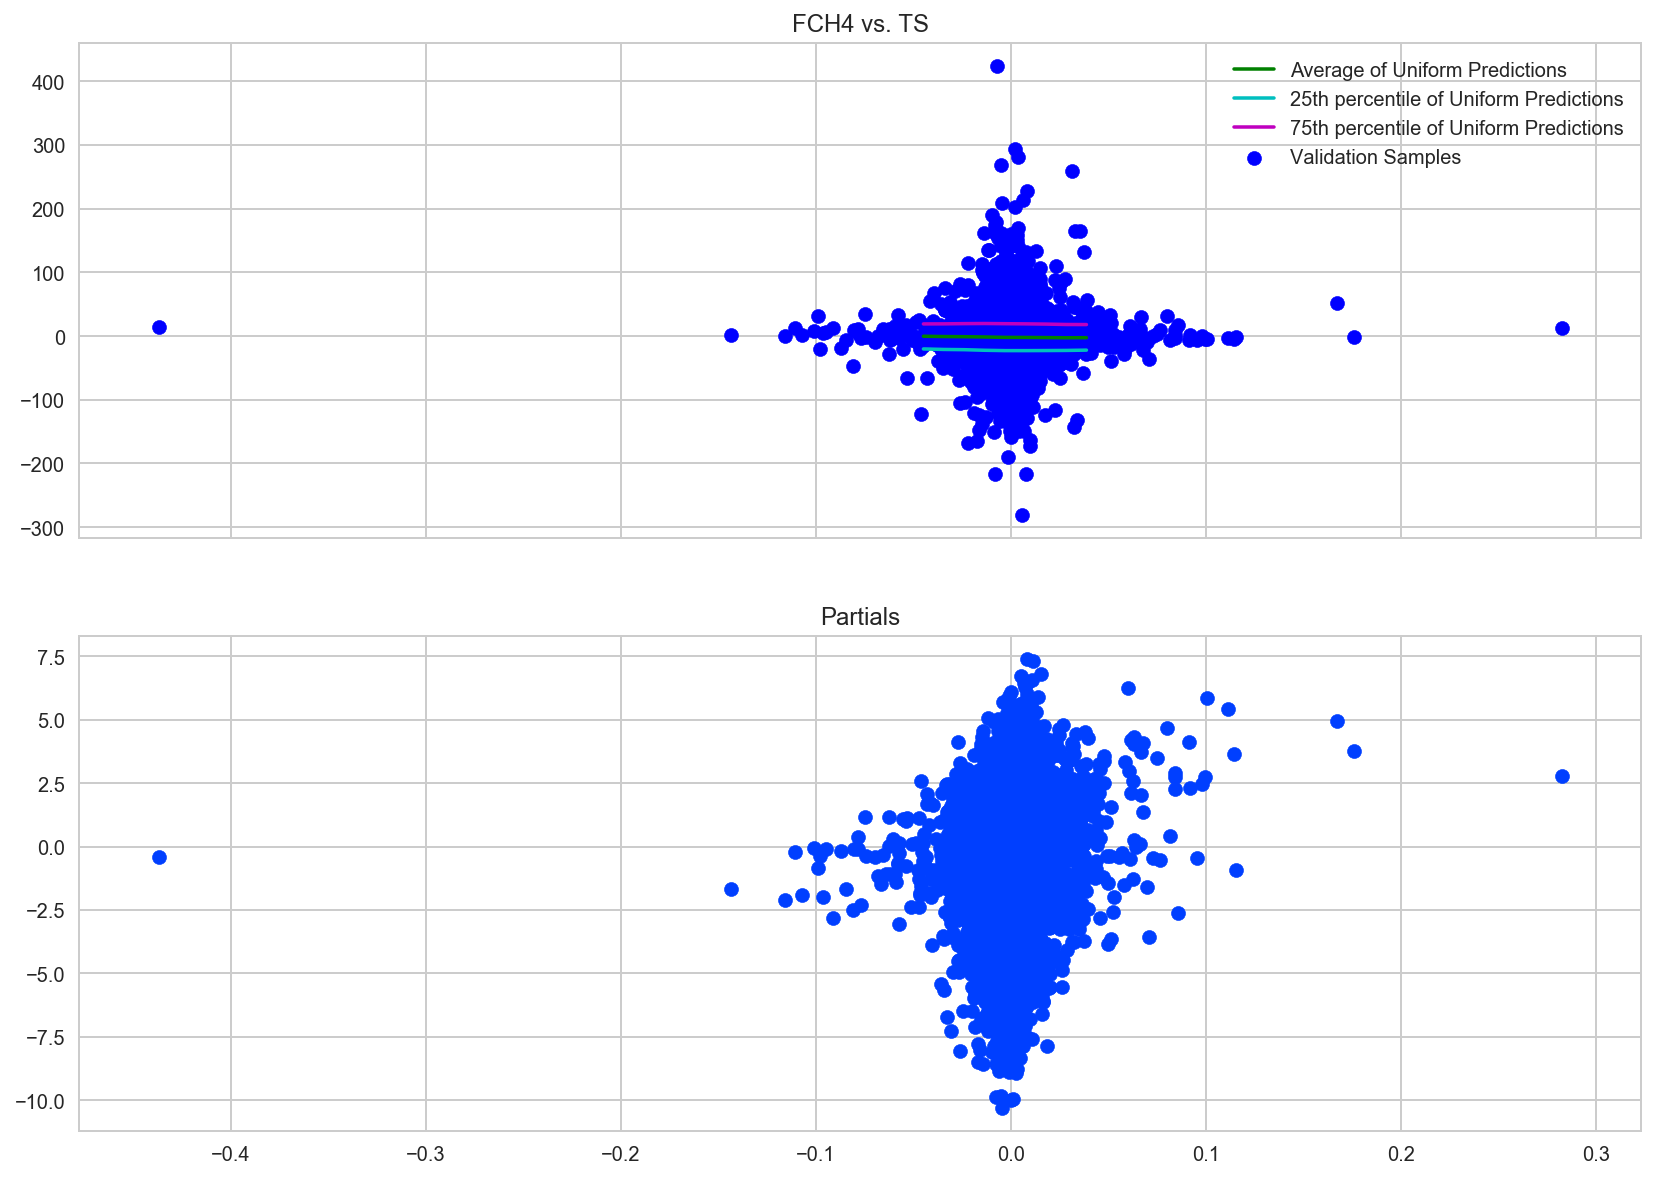

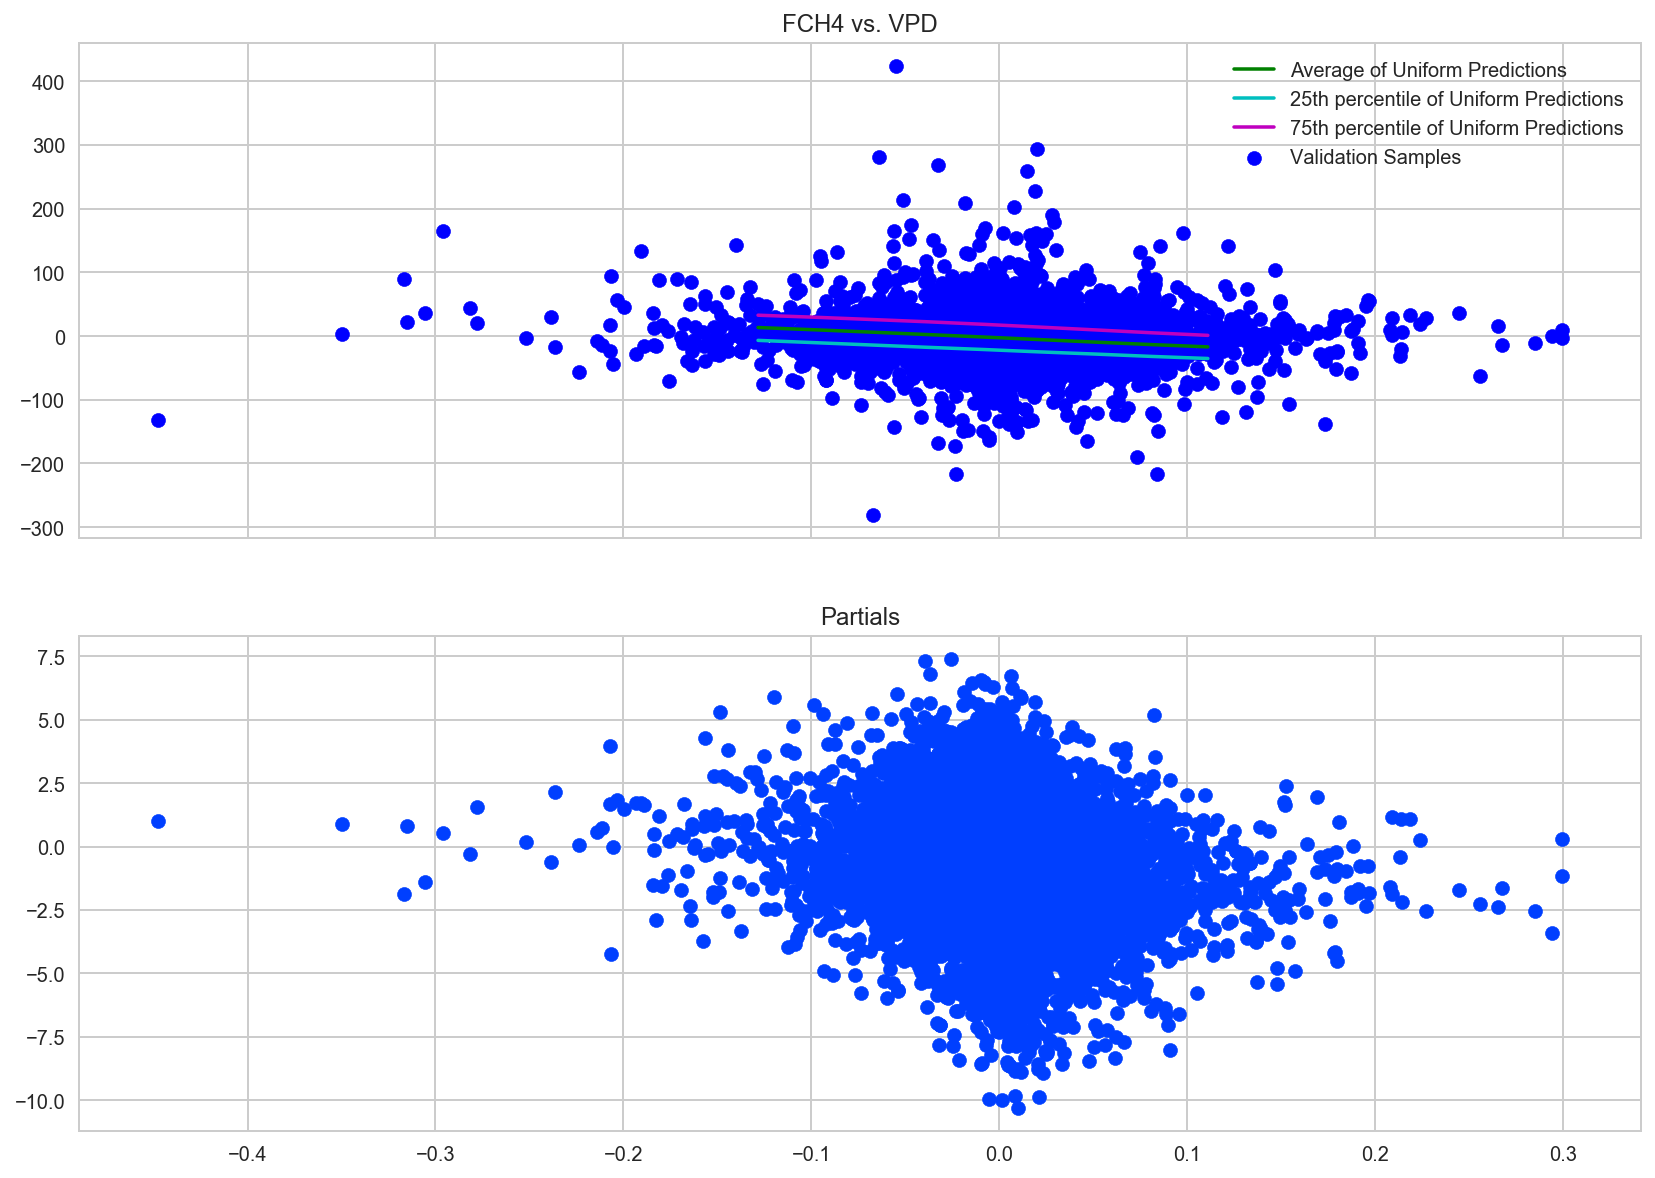

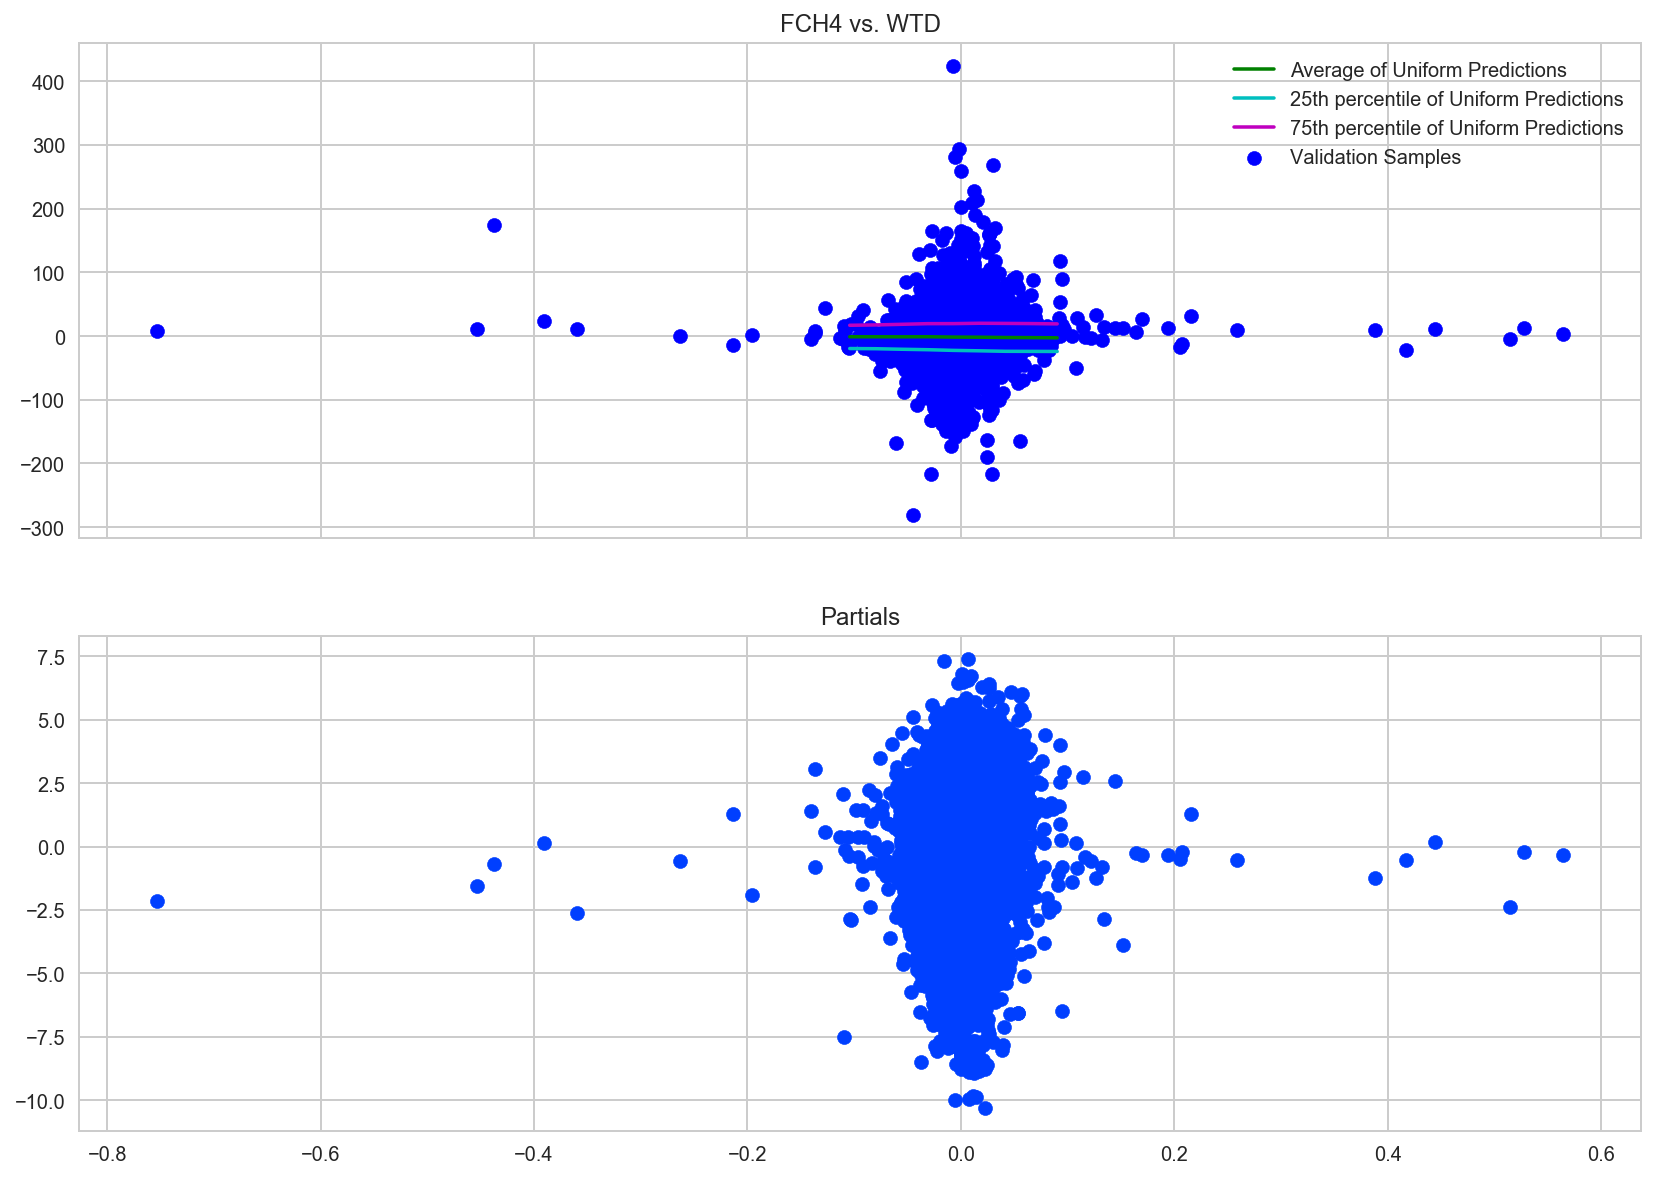

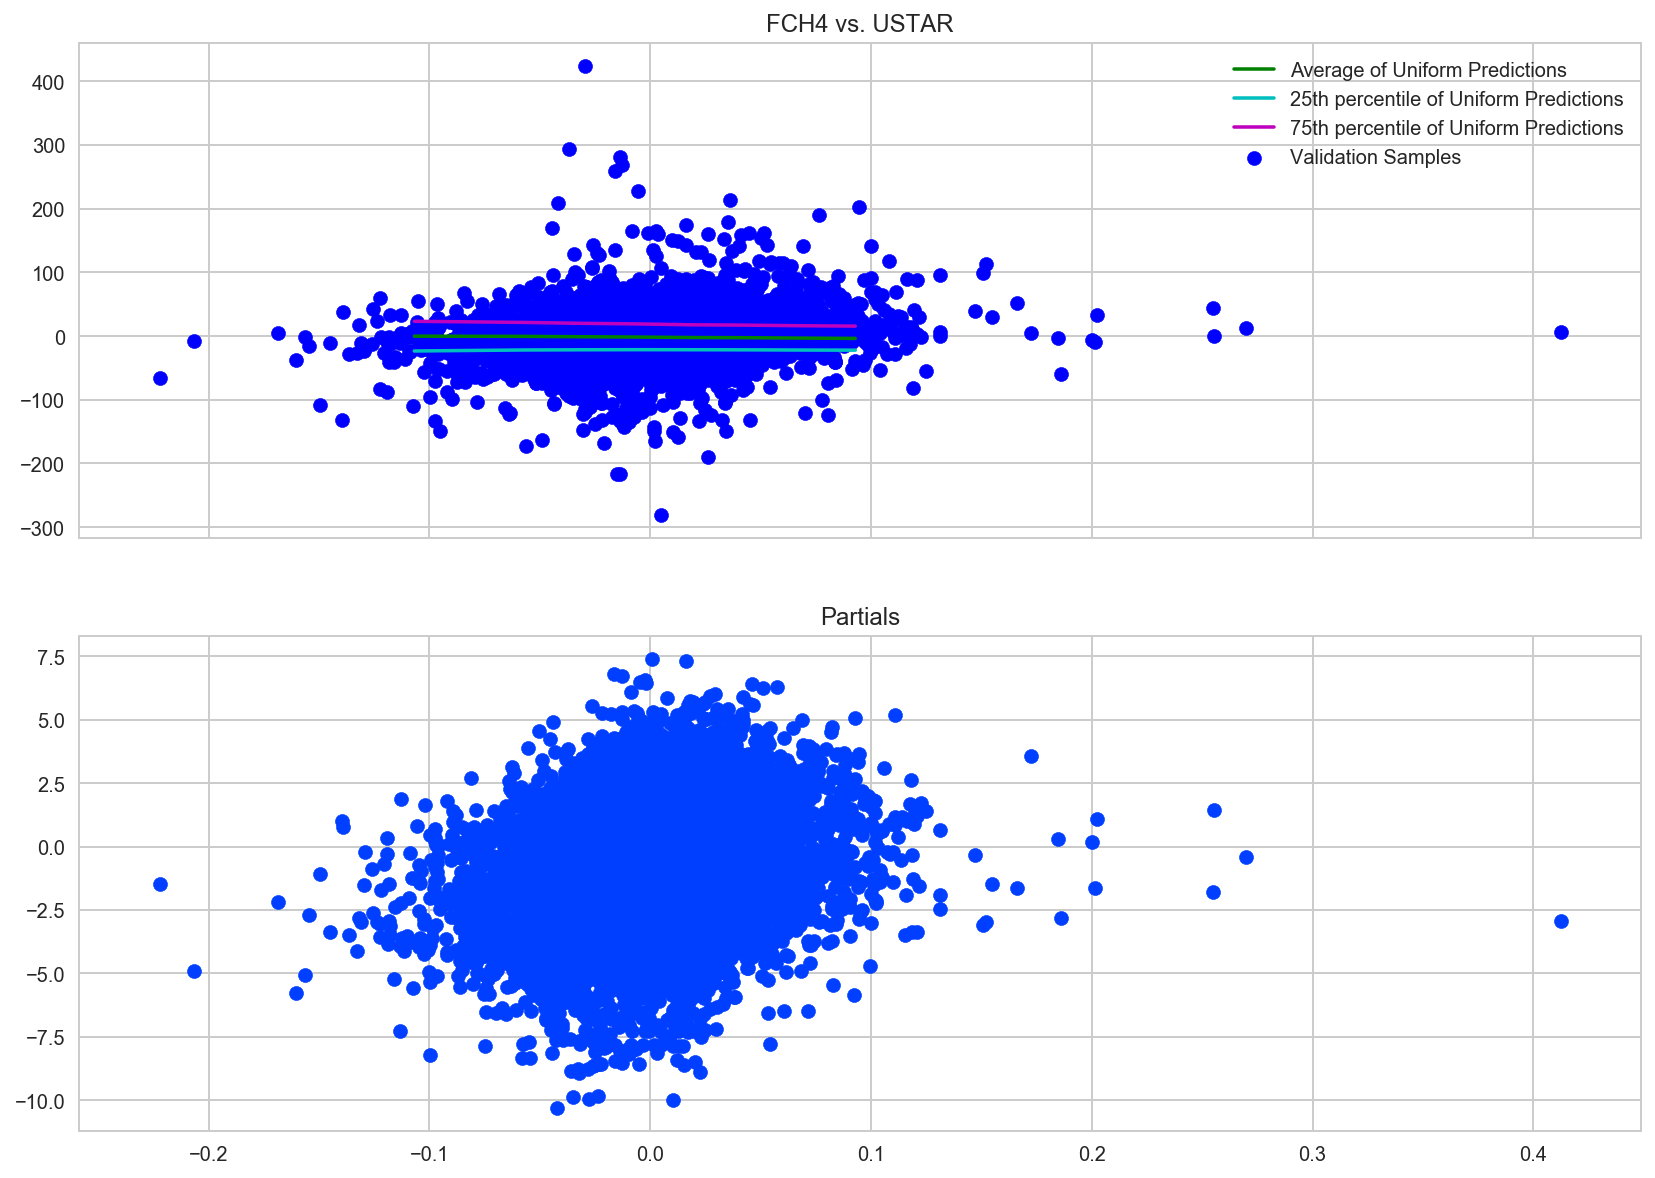

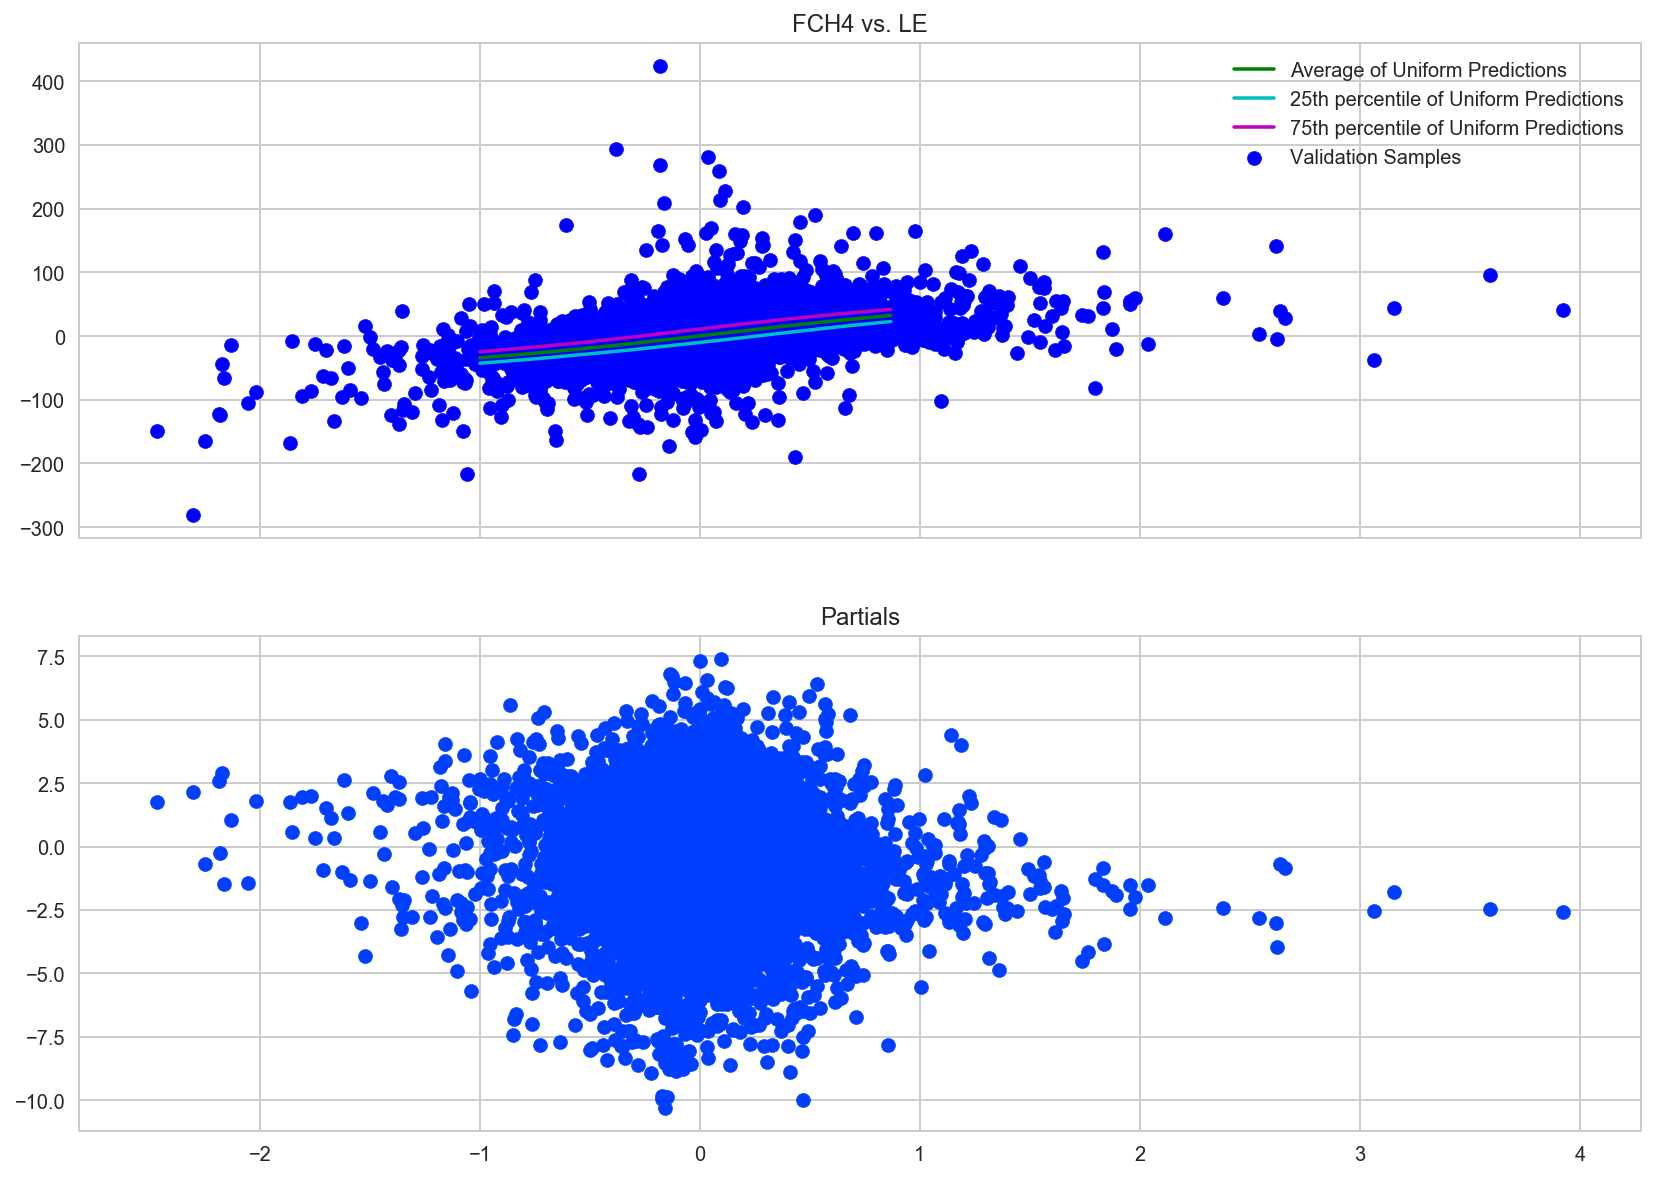

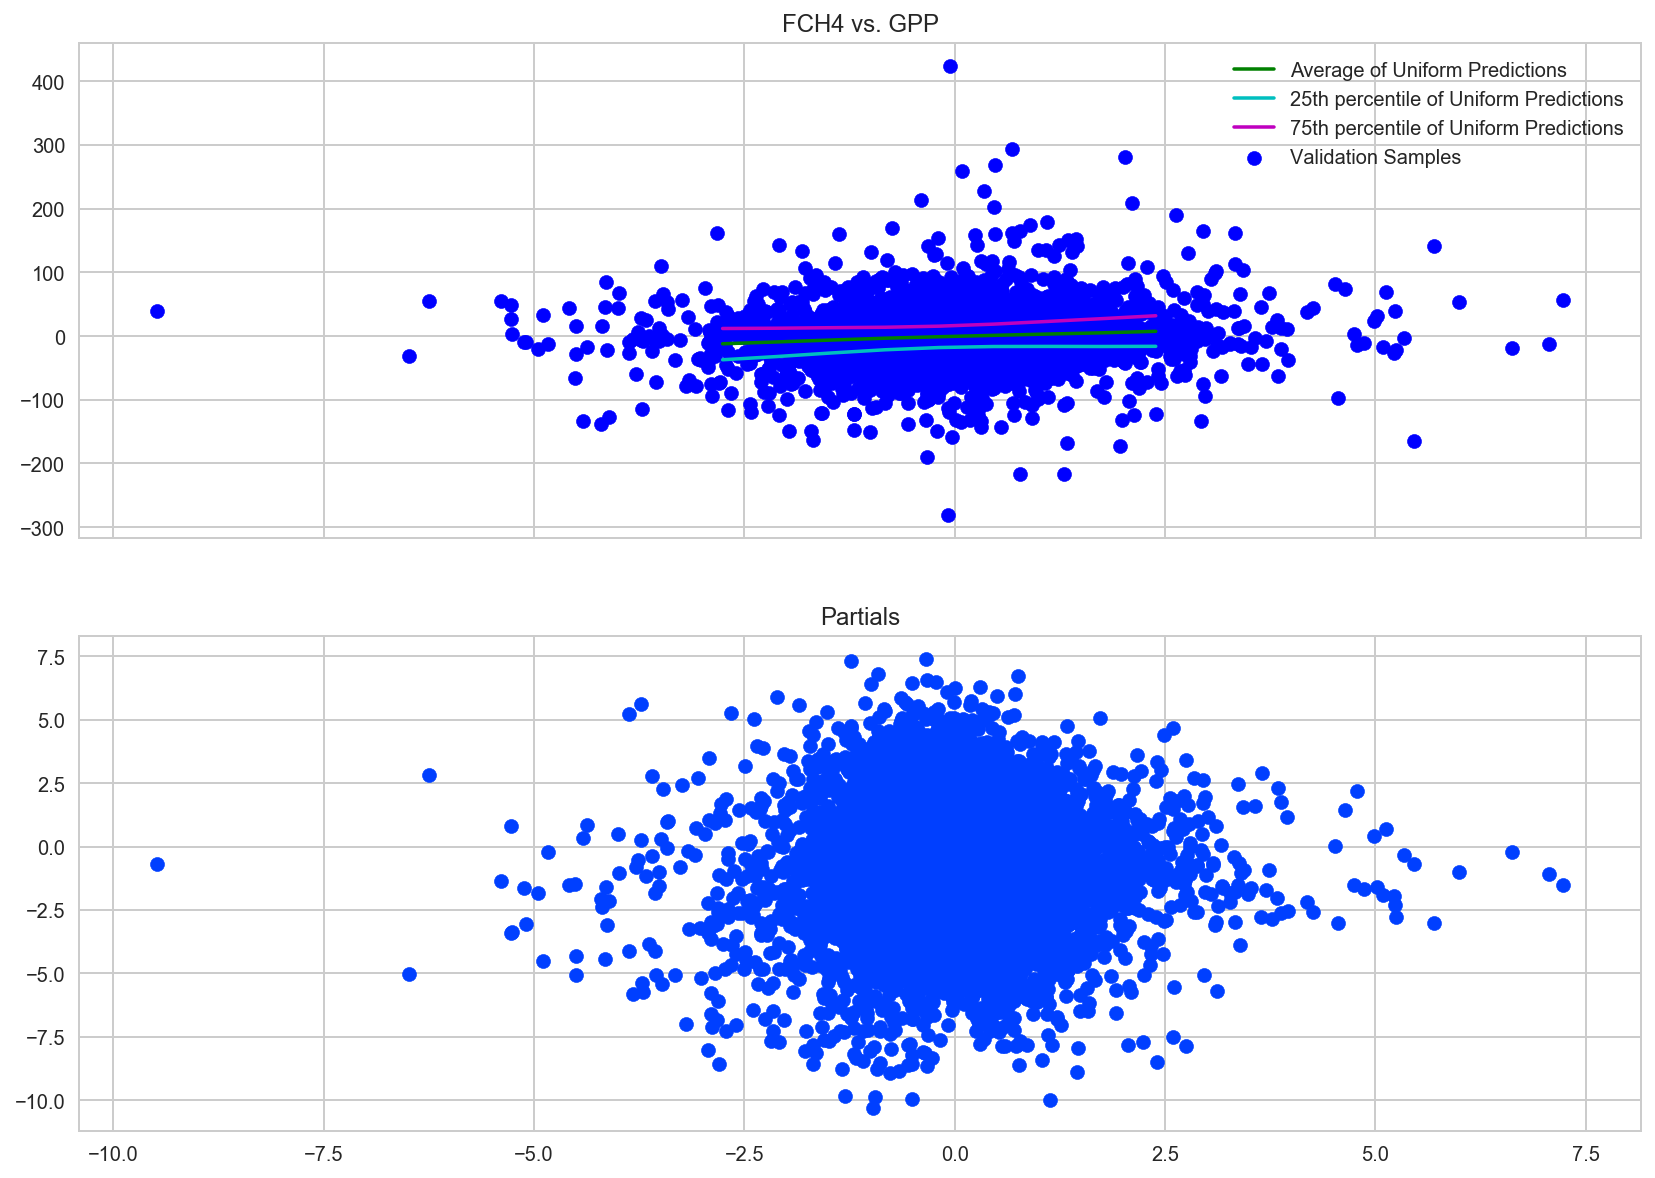

In [11]:
for i, x_var in enumerate(X_vars):
    for j, y_var in enumerate(y_vars):
        f, axarr = plt.subplots(2, sharex=True)
        axarr[0].set_title("{y_var} vs. {x_var}".format(y_var=y_var, x_var=x_var))
#         sns.kdeplot(X_uniform_inverse[:, x_idx], uniform_preds[:, y_idx], ax=axarr[0], cmap="Blues", shade=True, shade_lowest=False)

        axarr[0].scatter(X_val_inverse[:, i], y_val['FCH4'], c='b', label='Validation Samples')
#         axarr[0].scatter(X_uniform_inverse[:, i], uniform_preds[:, j], c='r', label='Uniform Predictions')
        plot_uniform_line(axarr[0], X_uniform_inverse, uniform_preds, i, j)
        axarr[0].legend()
        axarr[1].set_title("Partials")
        axarr[1].scatter(X_val_inverse[:, i], partials[0][:, j])
        plt.show()

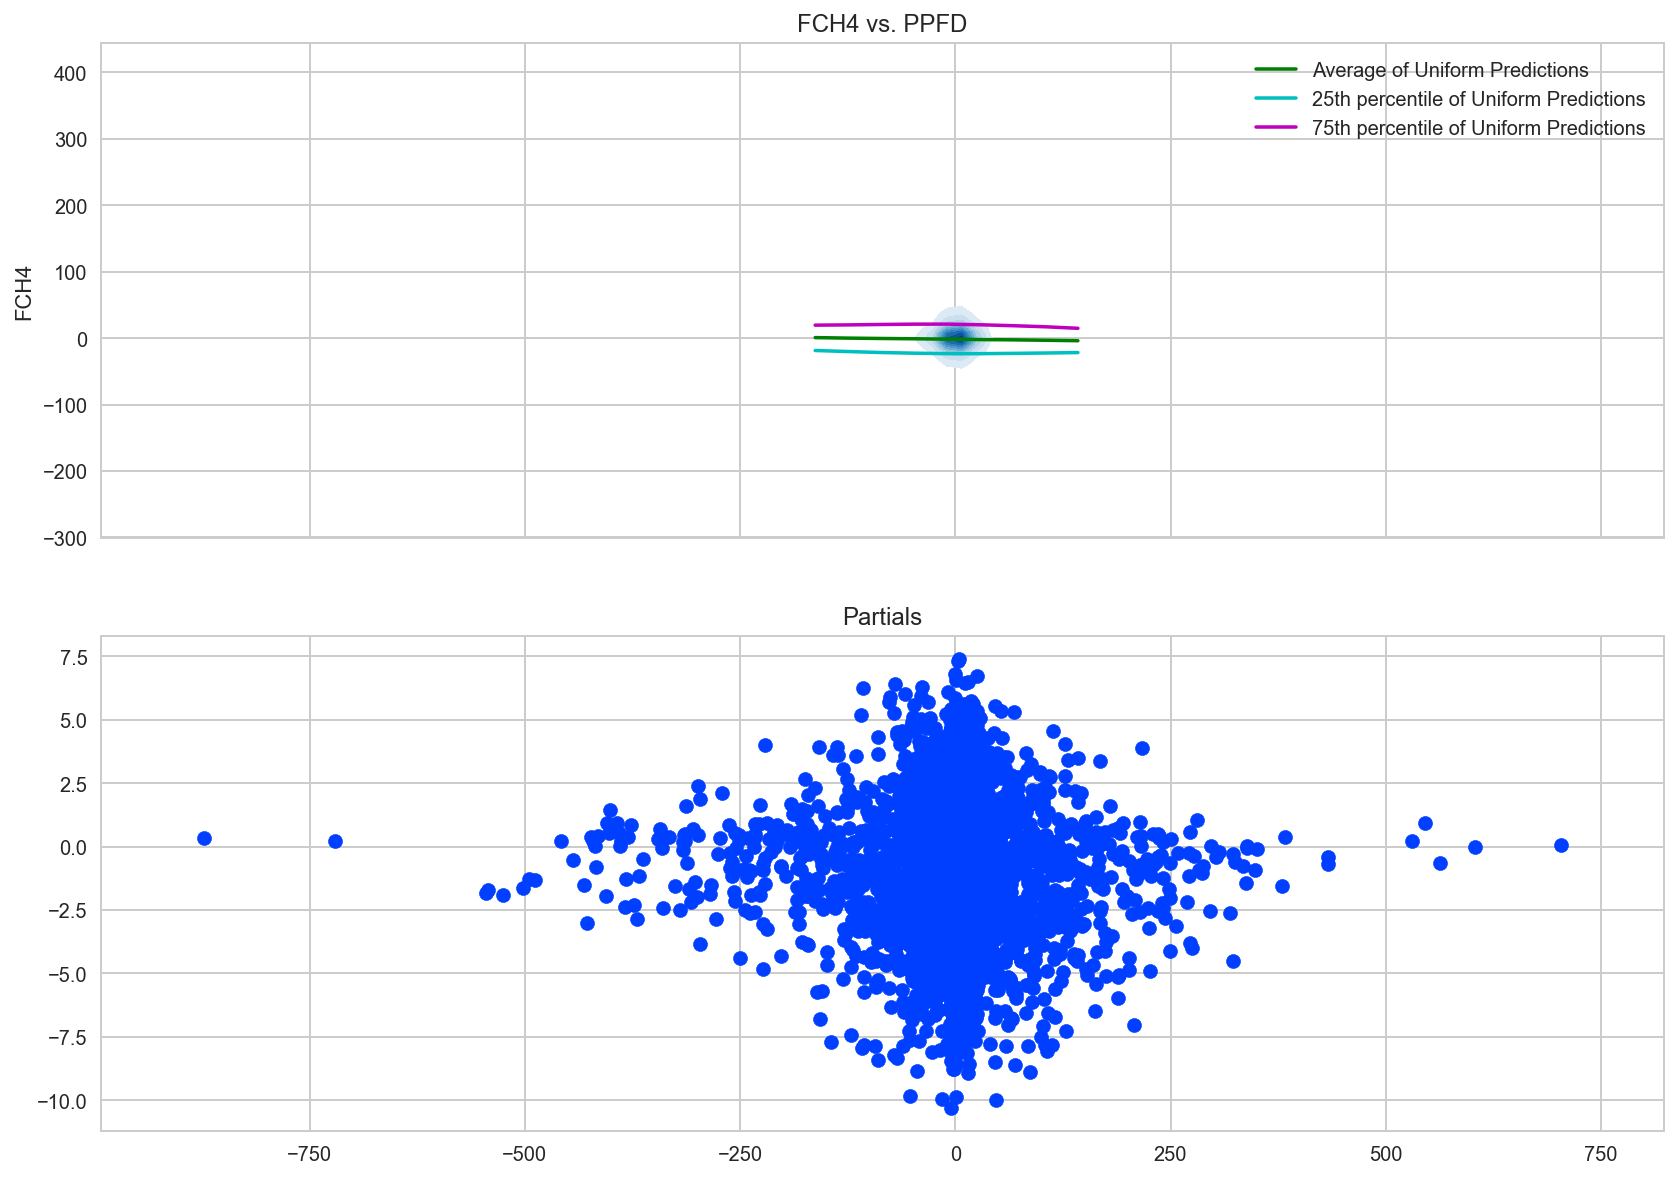

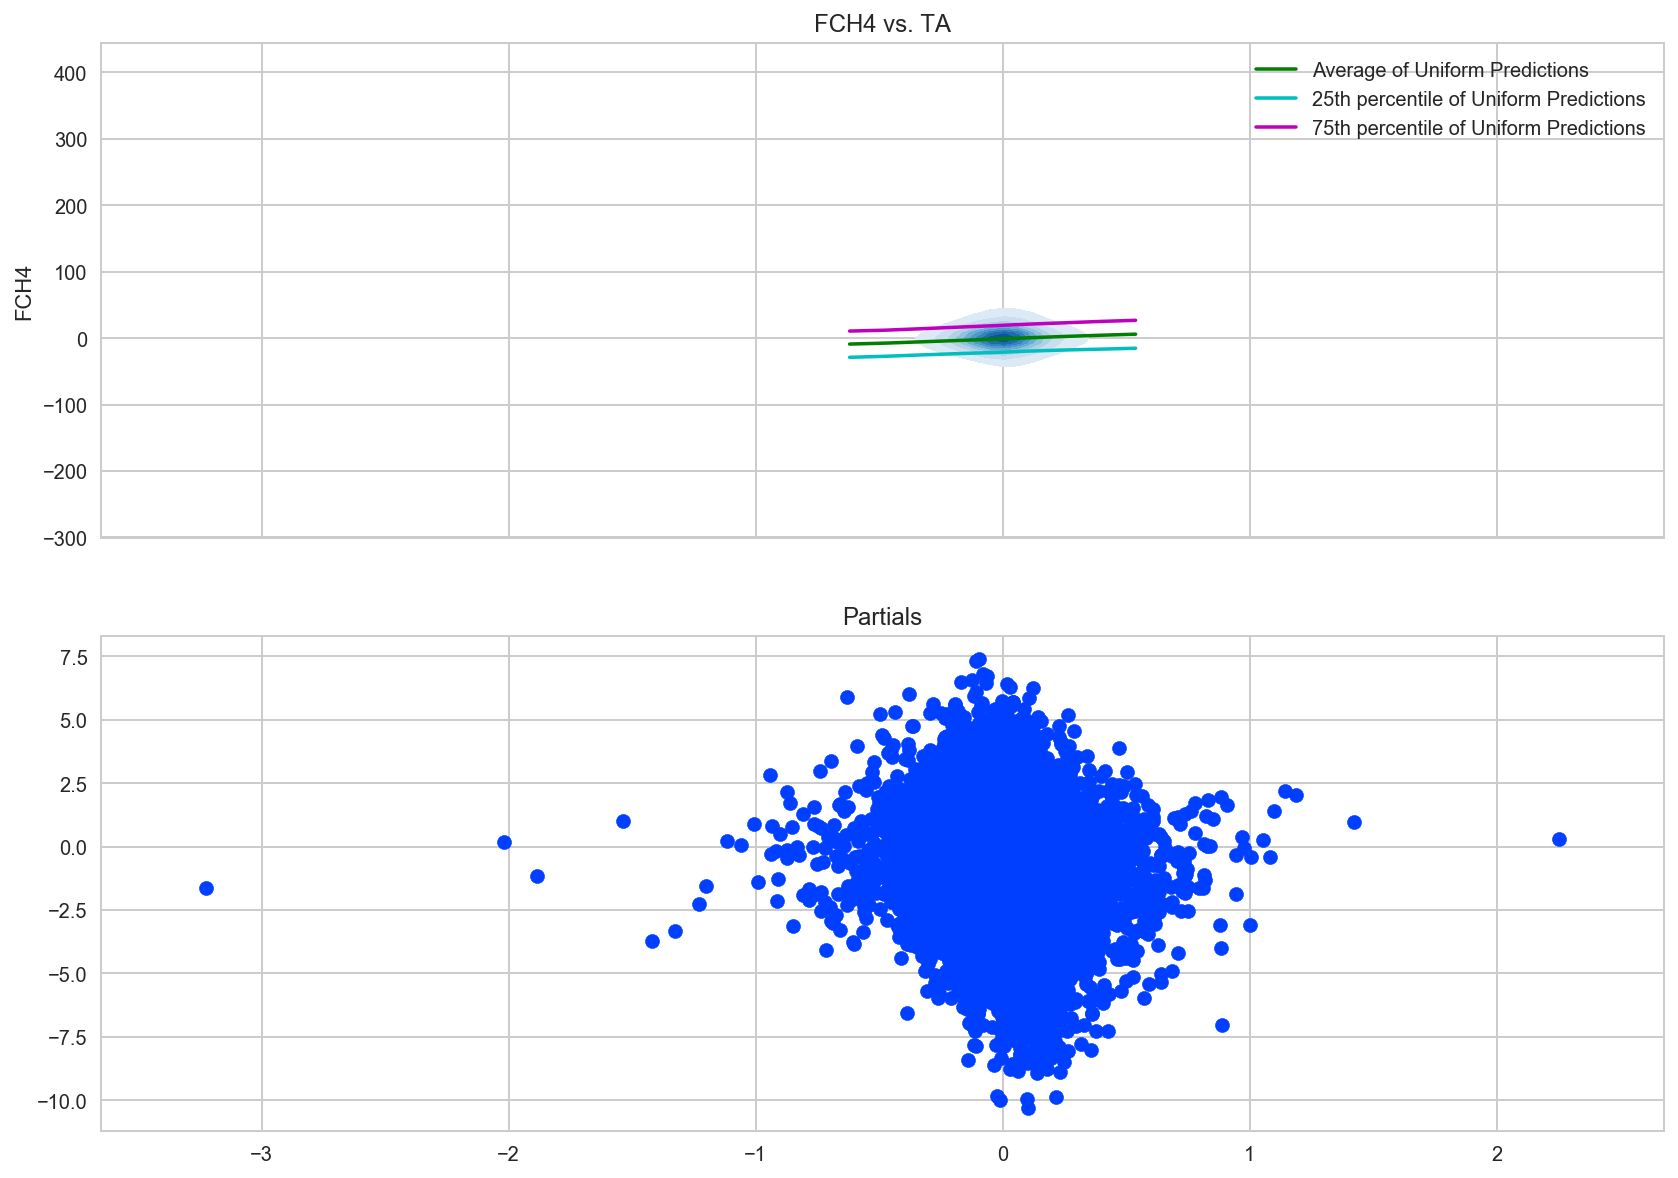

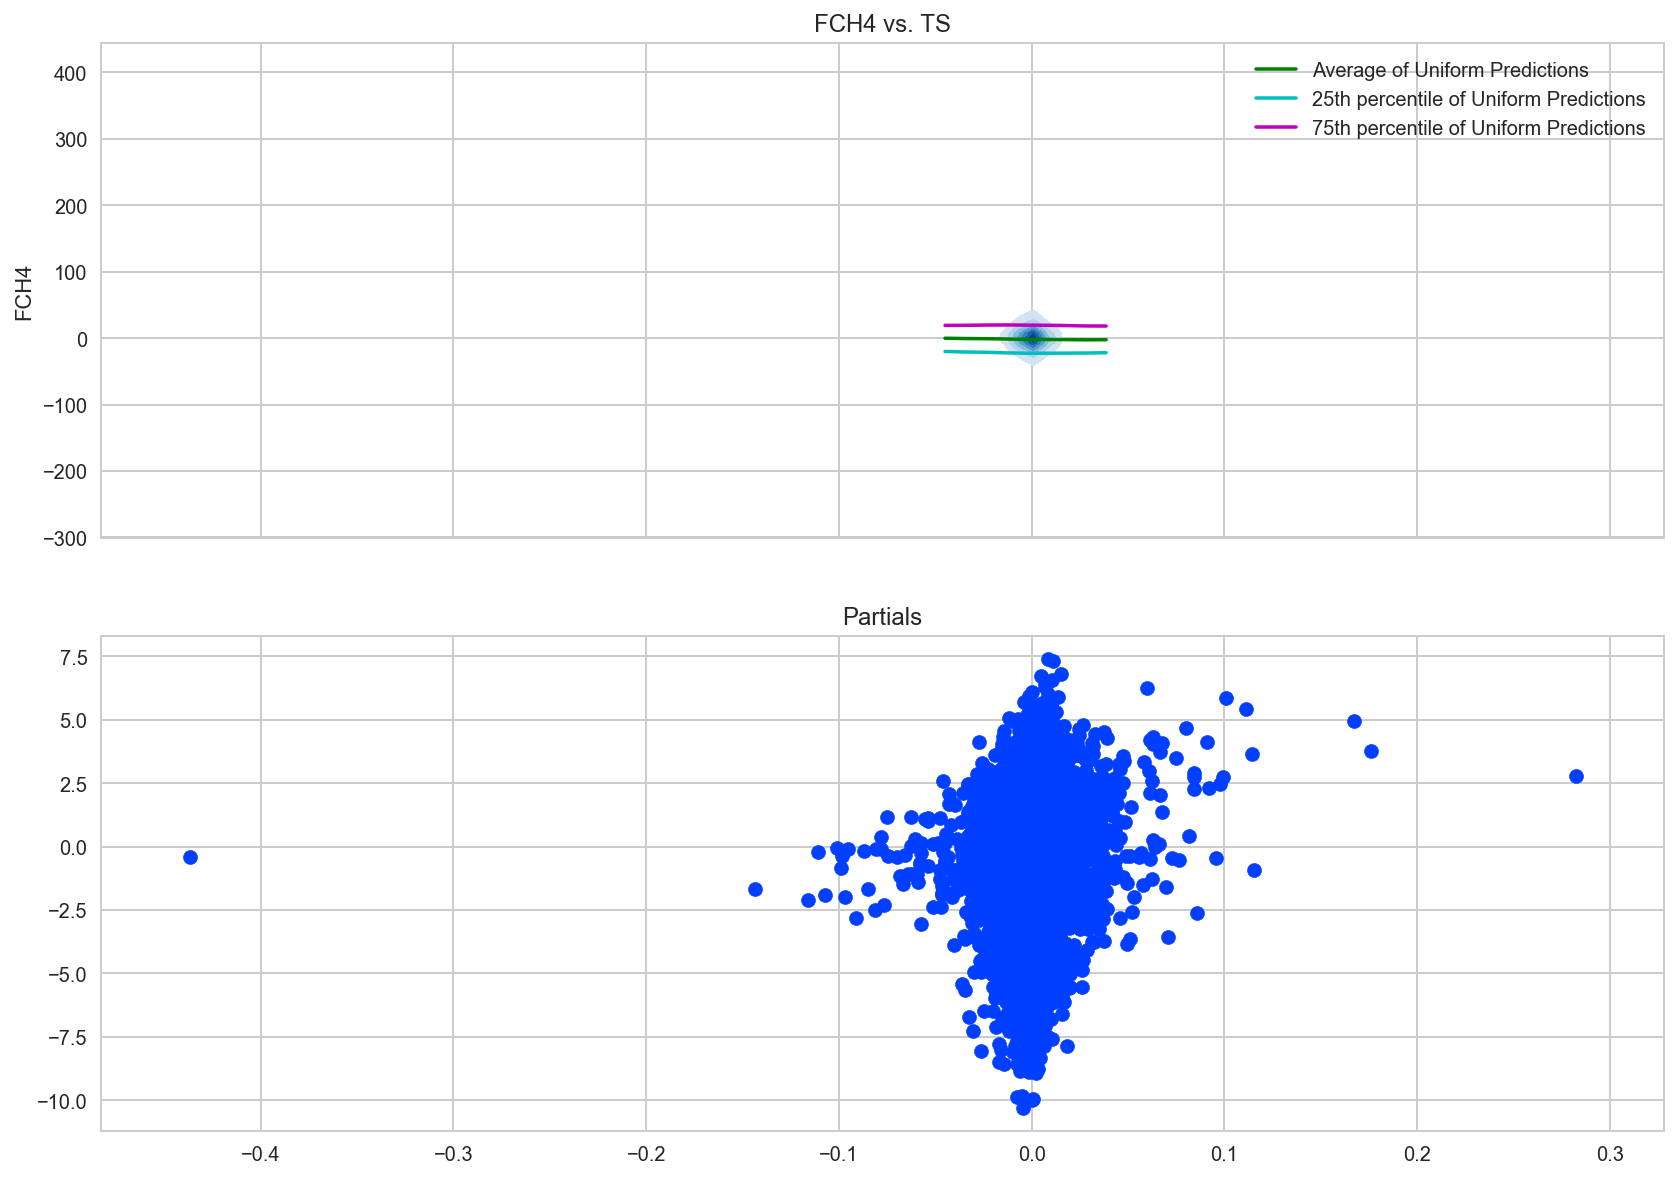

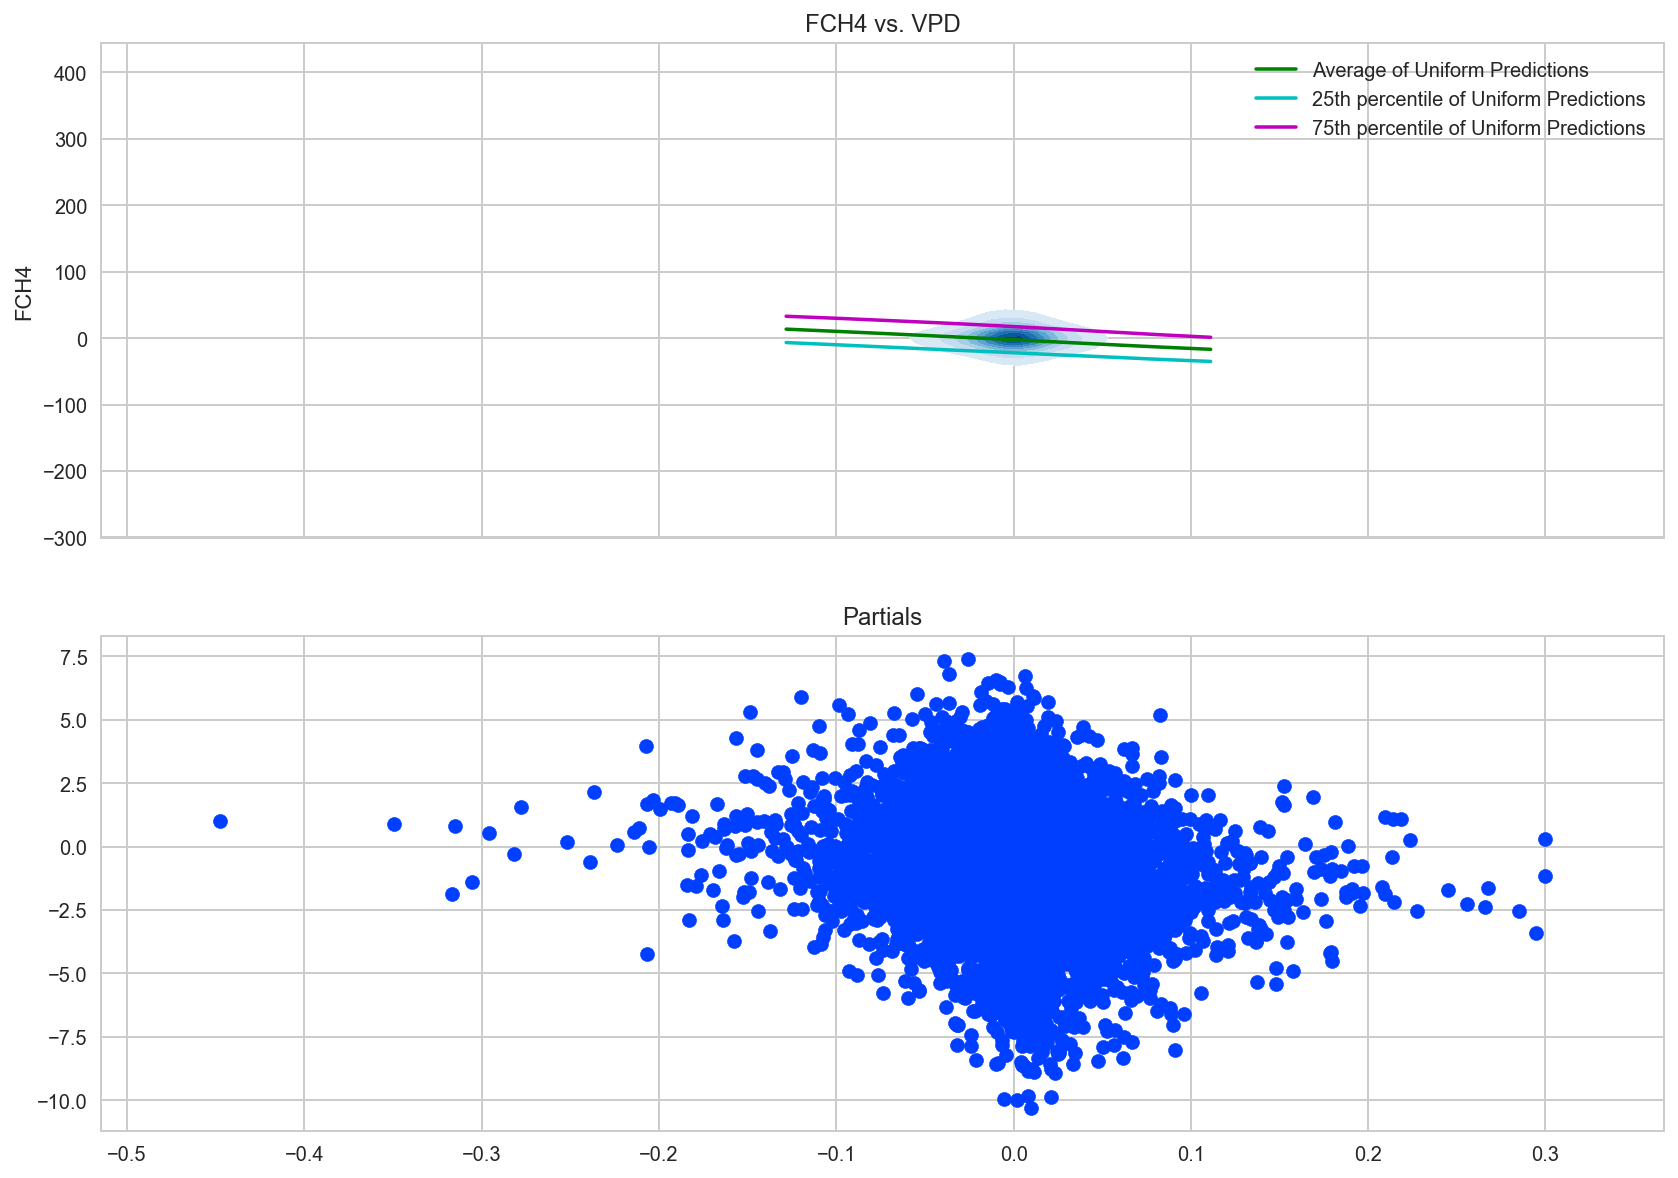

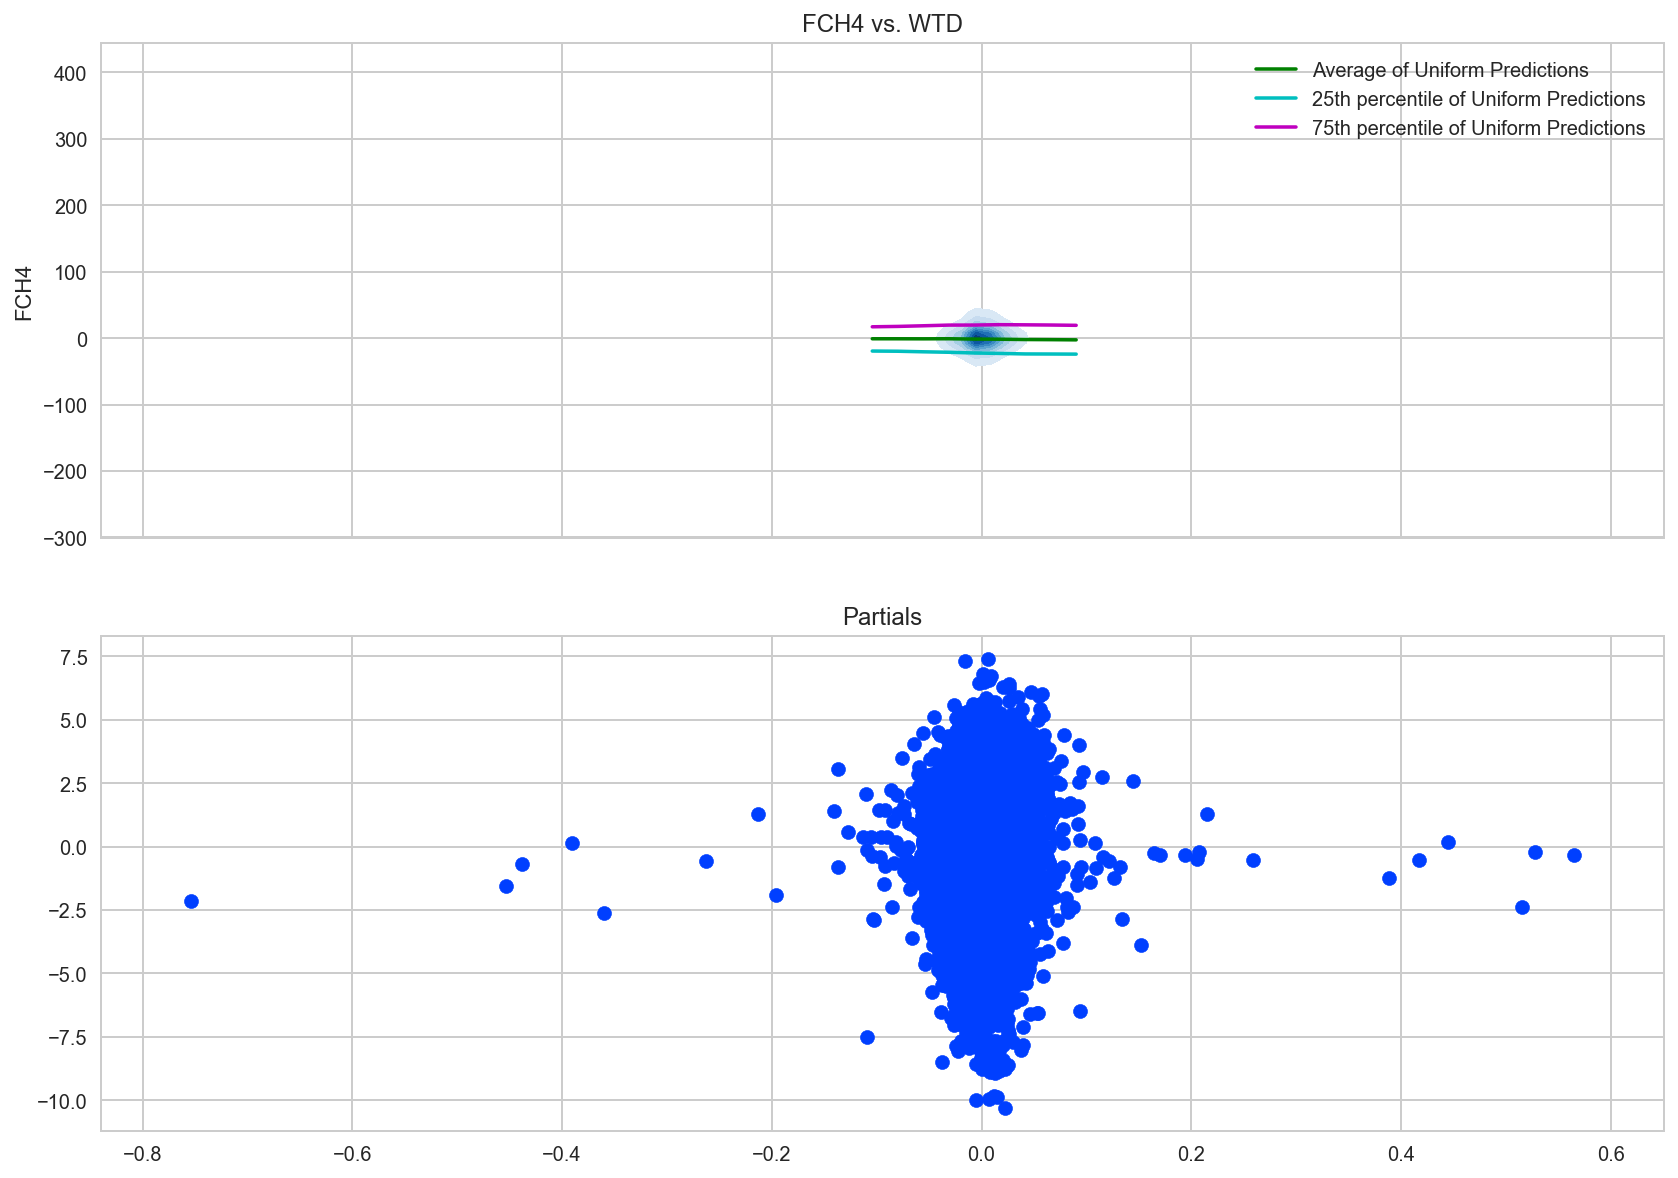

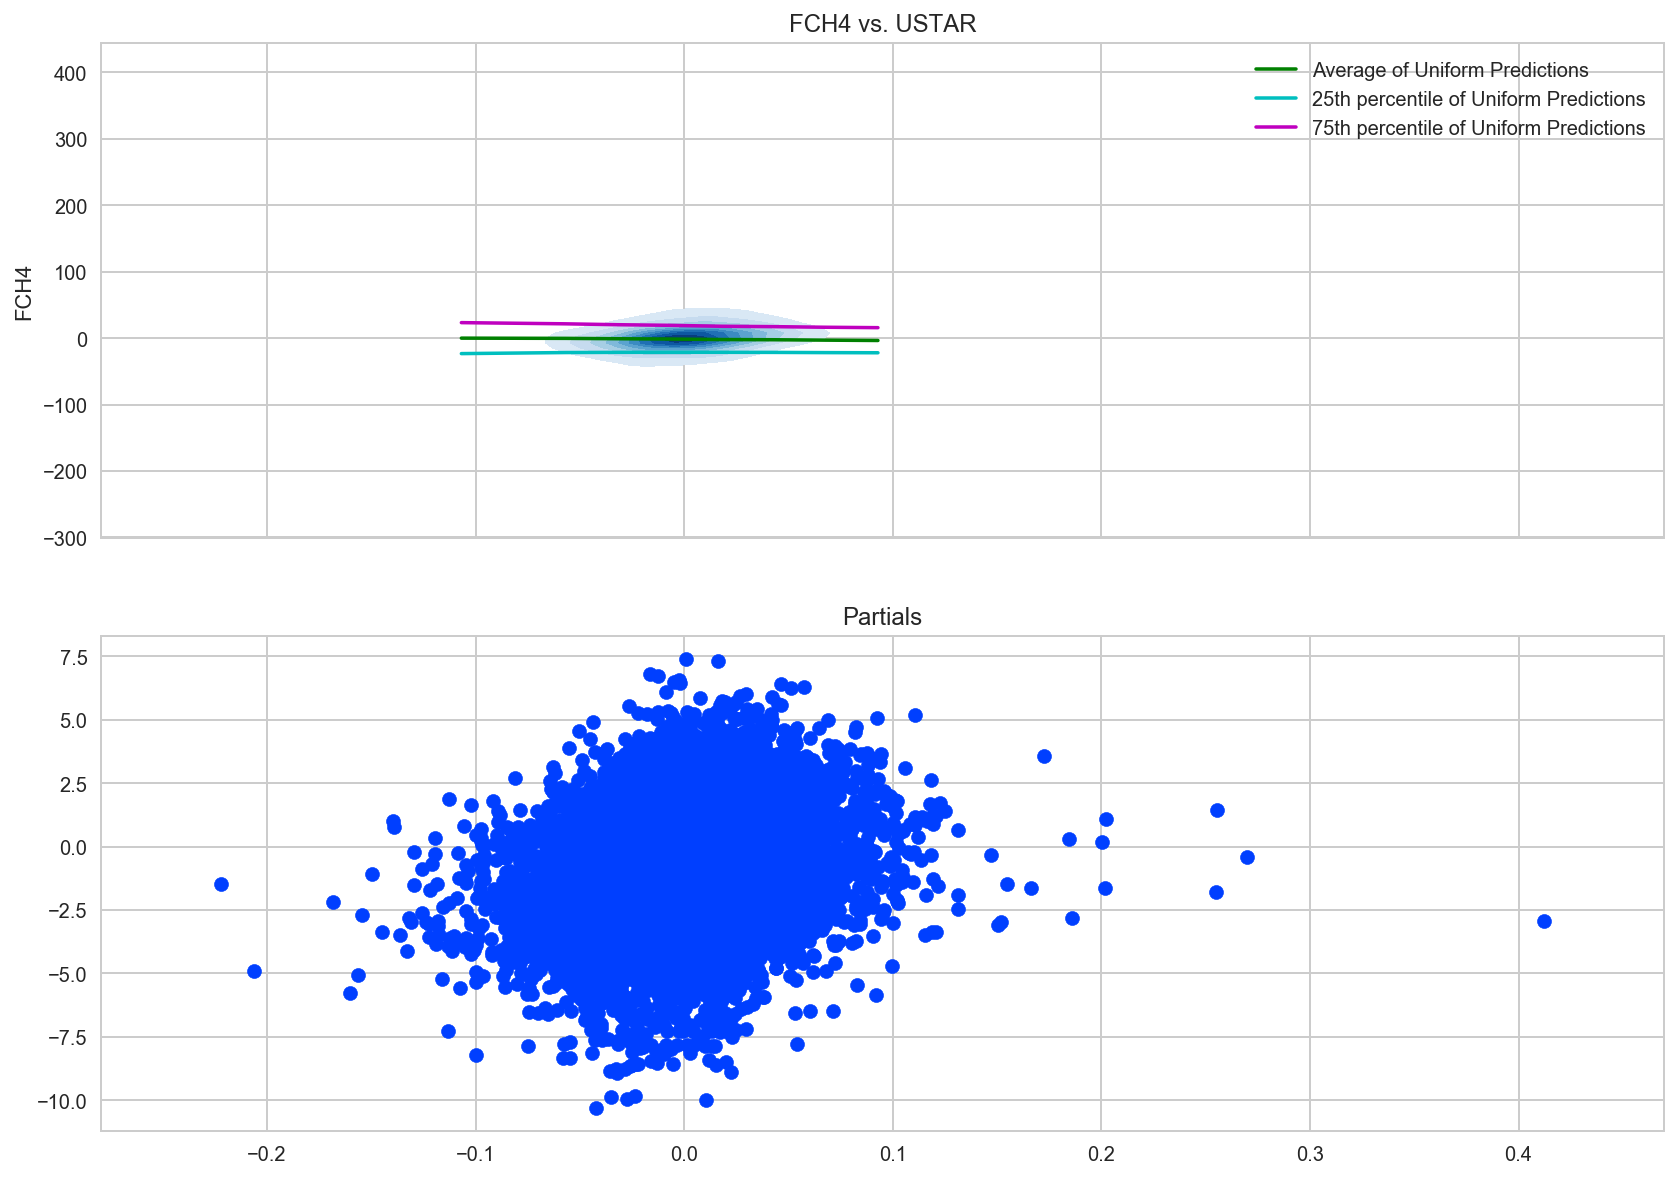

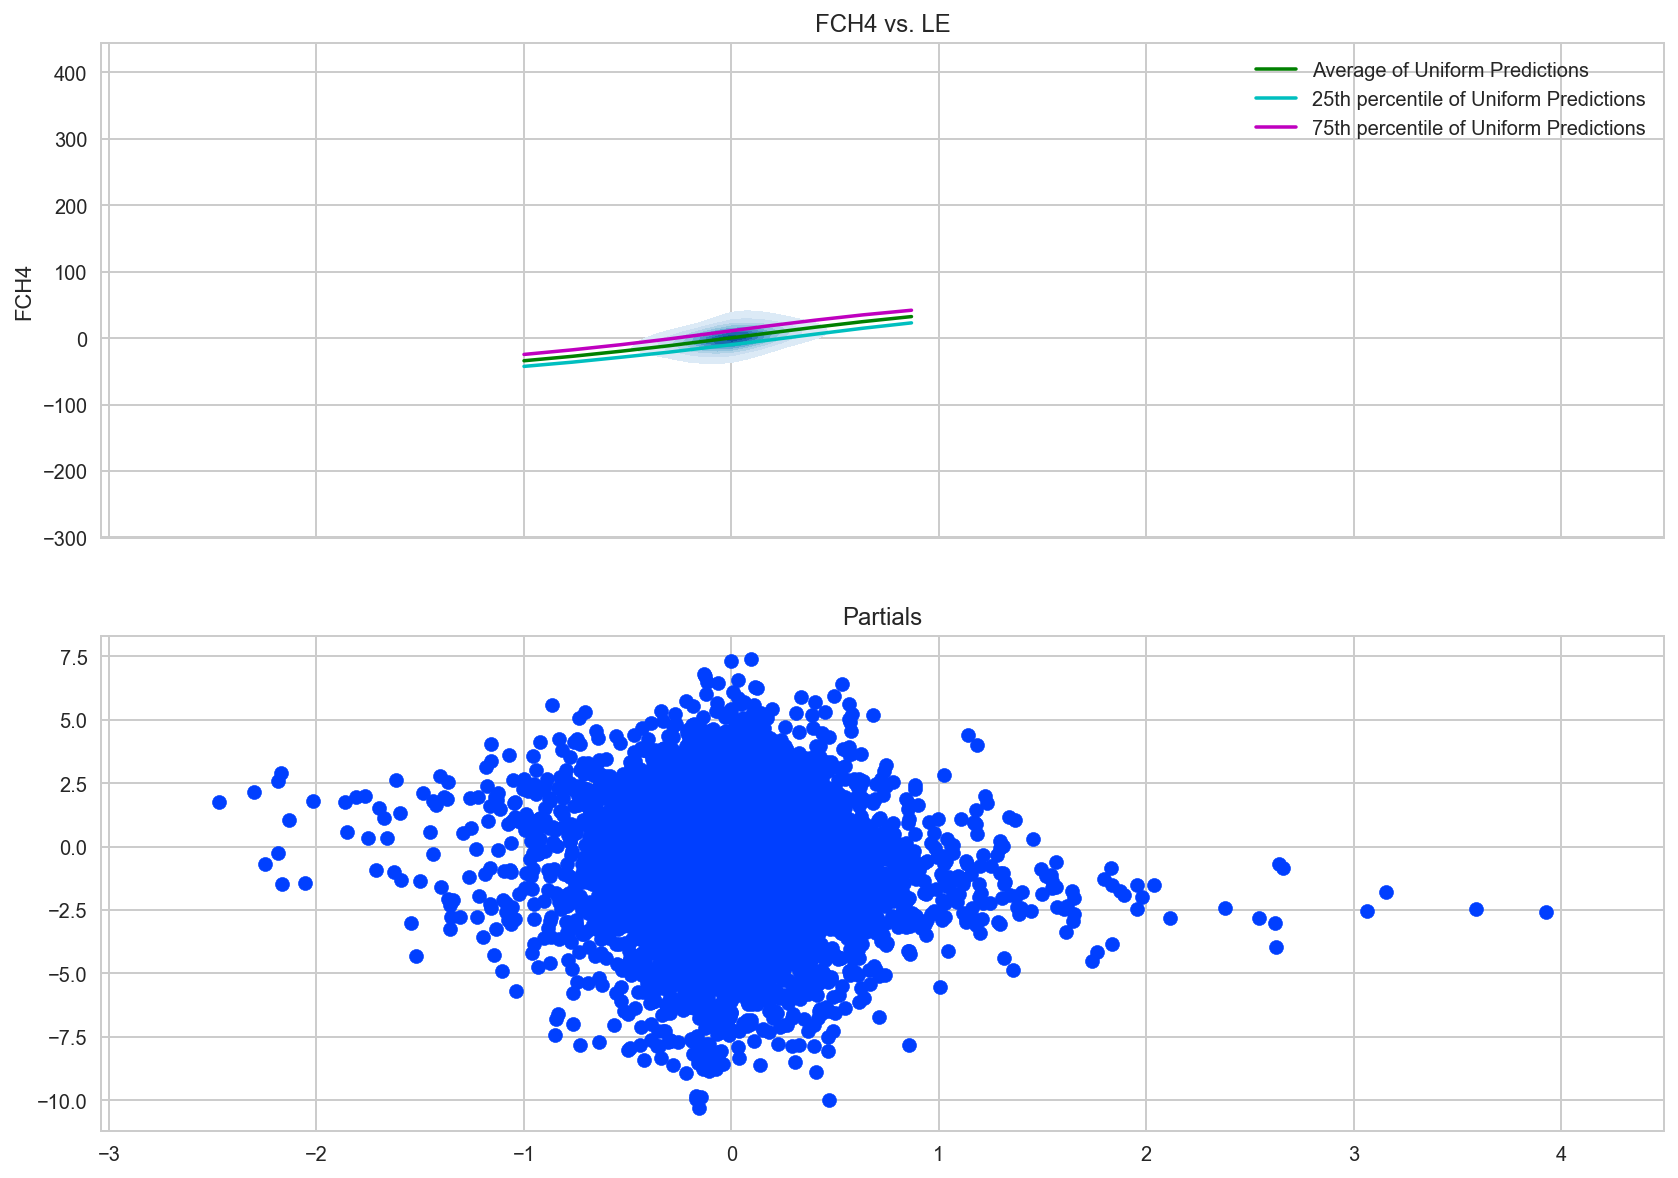

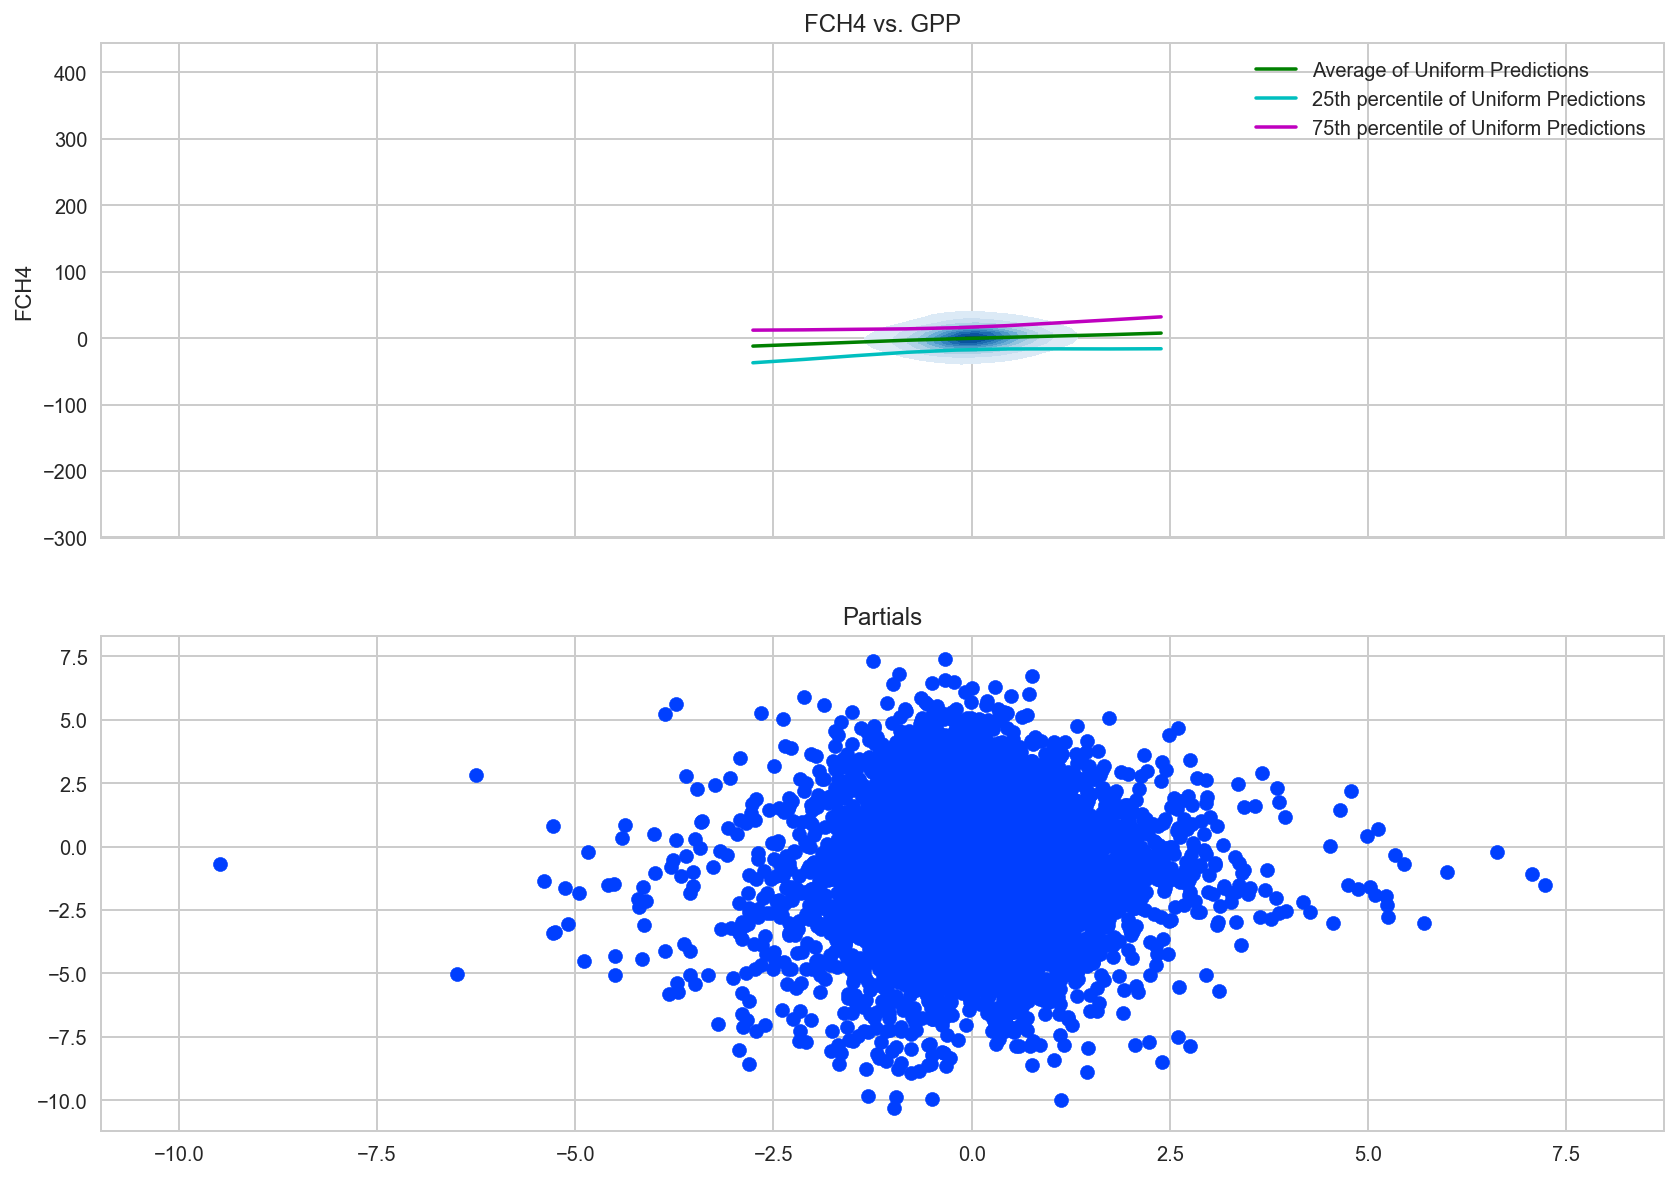

In [12]:
for i, x_var in enumerate(X_vars):
    for j, y_var in enumerate(y_vars):
        f, axarr = plt.subplots(2, sharex=True)
        axarr[0].set_title("{y_var} vs. {x_var}".format(y_var=y_var, x_var=x_var))
#         sns.kdeplot(X_uniform_inverse[:, x_idx], uniform_preds[:, y_idx], ax=axarr[0], cmap="Blues", shade=True, shade_lowest=False)

#         axarr[0].scatter(X_uniform_inverse[:, x_idx], uniform_preds[:, y_idx], c='r', label='Uniform Predictions')
#         sns.kdeplot(X_uniform_inverse[:, x_idx], uniform_preds[:, y_idx], ax=axarr[0], cmap="Blues", shade=True, shade_lowest=False)
        sns.kdeplot(X_val_inverse[:, i], y_val[y_var], ax=axarr[0], cmap="Blues", shade=True, shade_lowest=False)

#         axarr[0].scatter(X_val_inverse[:, x_idx], y_val['FCH4'], c='b', label='Validation Samples')
        plot_uniform_line(axarr[0], X_uniform_inverse, uniform_preds, i, j)
        axarr[0].legend()
        axarr[1].set_title("Partials")
        axarr[1].scatter(X_val_inverse[:, i], partials[0][:, j])
        plt.show()